## Parte 1 - INFRAESTRUTURA

In [96]:
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot  as plt 
import seaborn as sns
import sklearn
import sklearn.cluster
import sklearn.metrics


In [97]:
#informando a versão do python e também o ambiente virtual utilizado
print(f'A versão do python instalada é: {sys.version}\nRodando no ambiente virtual: {sys.prefix}')

A versão do python instalada é: 3.13.1 | packaged by conda-forge | (main, Dec  5 2024, 21:02:16) [MSC v.1942 64 bit (AMD64)]
Rodando no ambiente virtual: c:\Users\Alan\miniconda3\envs\validacao


Este arquivo, em conjunto com o dataset, requirements.txt e um screenshot do ambiente de
desenvolvimento estão no github: https://github.com/AlansAlonso/PG-IA/tree/main/pd_validacao

## Parte 2 - BASE DE DADOS

A base de dados escolhida foi uma que possui todos os atributos de todos os jogadores presentes no jogo EA Sports FC 25. Minha escolha foi baseada em achar interessante a ideia de agrupar os jogadores com base em seus atributos, e quero conseguir definir com certa precisão a posição de cada um deles com base nisso. 

Quantidade de jogadores na base de dados:  17737
Existem Unnamed: 0.1                 0
Unnamed: 0                   0
Rank                         0
Name                         0
OVR                          0
PAC                          0
SHO                          0
PAS                          0
DRI                          0
DEF                          0
PHY                          0
Acceleration                 0
Sprint Speed                 0
Positioning                  0
Finishing                    0
Shot Power                   0
Long Shots                   0
Volleys                      0
Penalties                    0
Vision                       0
Crossing                     0
Free Kick Accuracy           0
Short Passing                0
Long Passing                 0
Curve                        0
Dribbling                    0
Agility                      0
Balance                      0
Reactions                    0
Ball Control                 0
Composure    

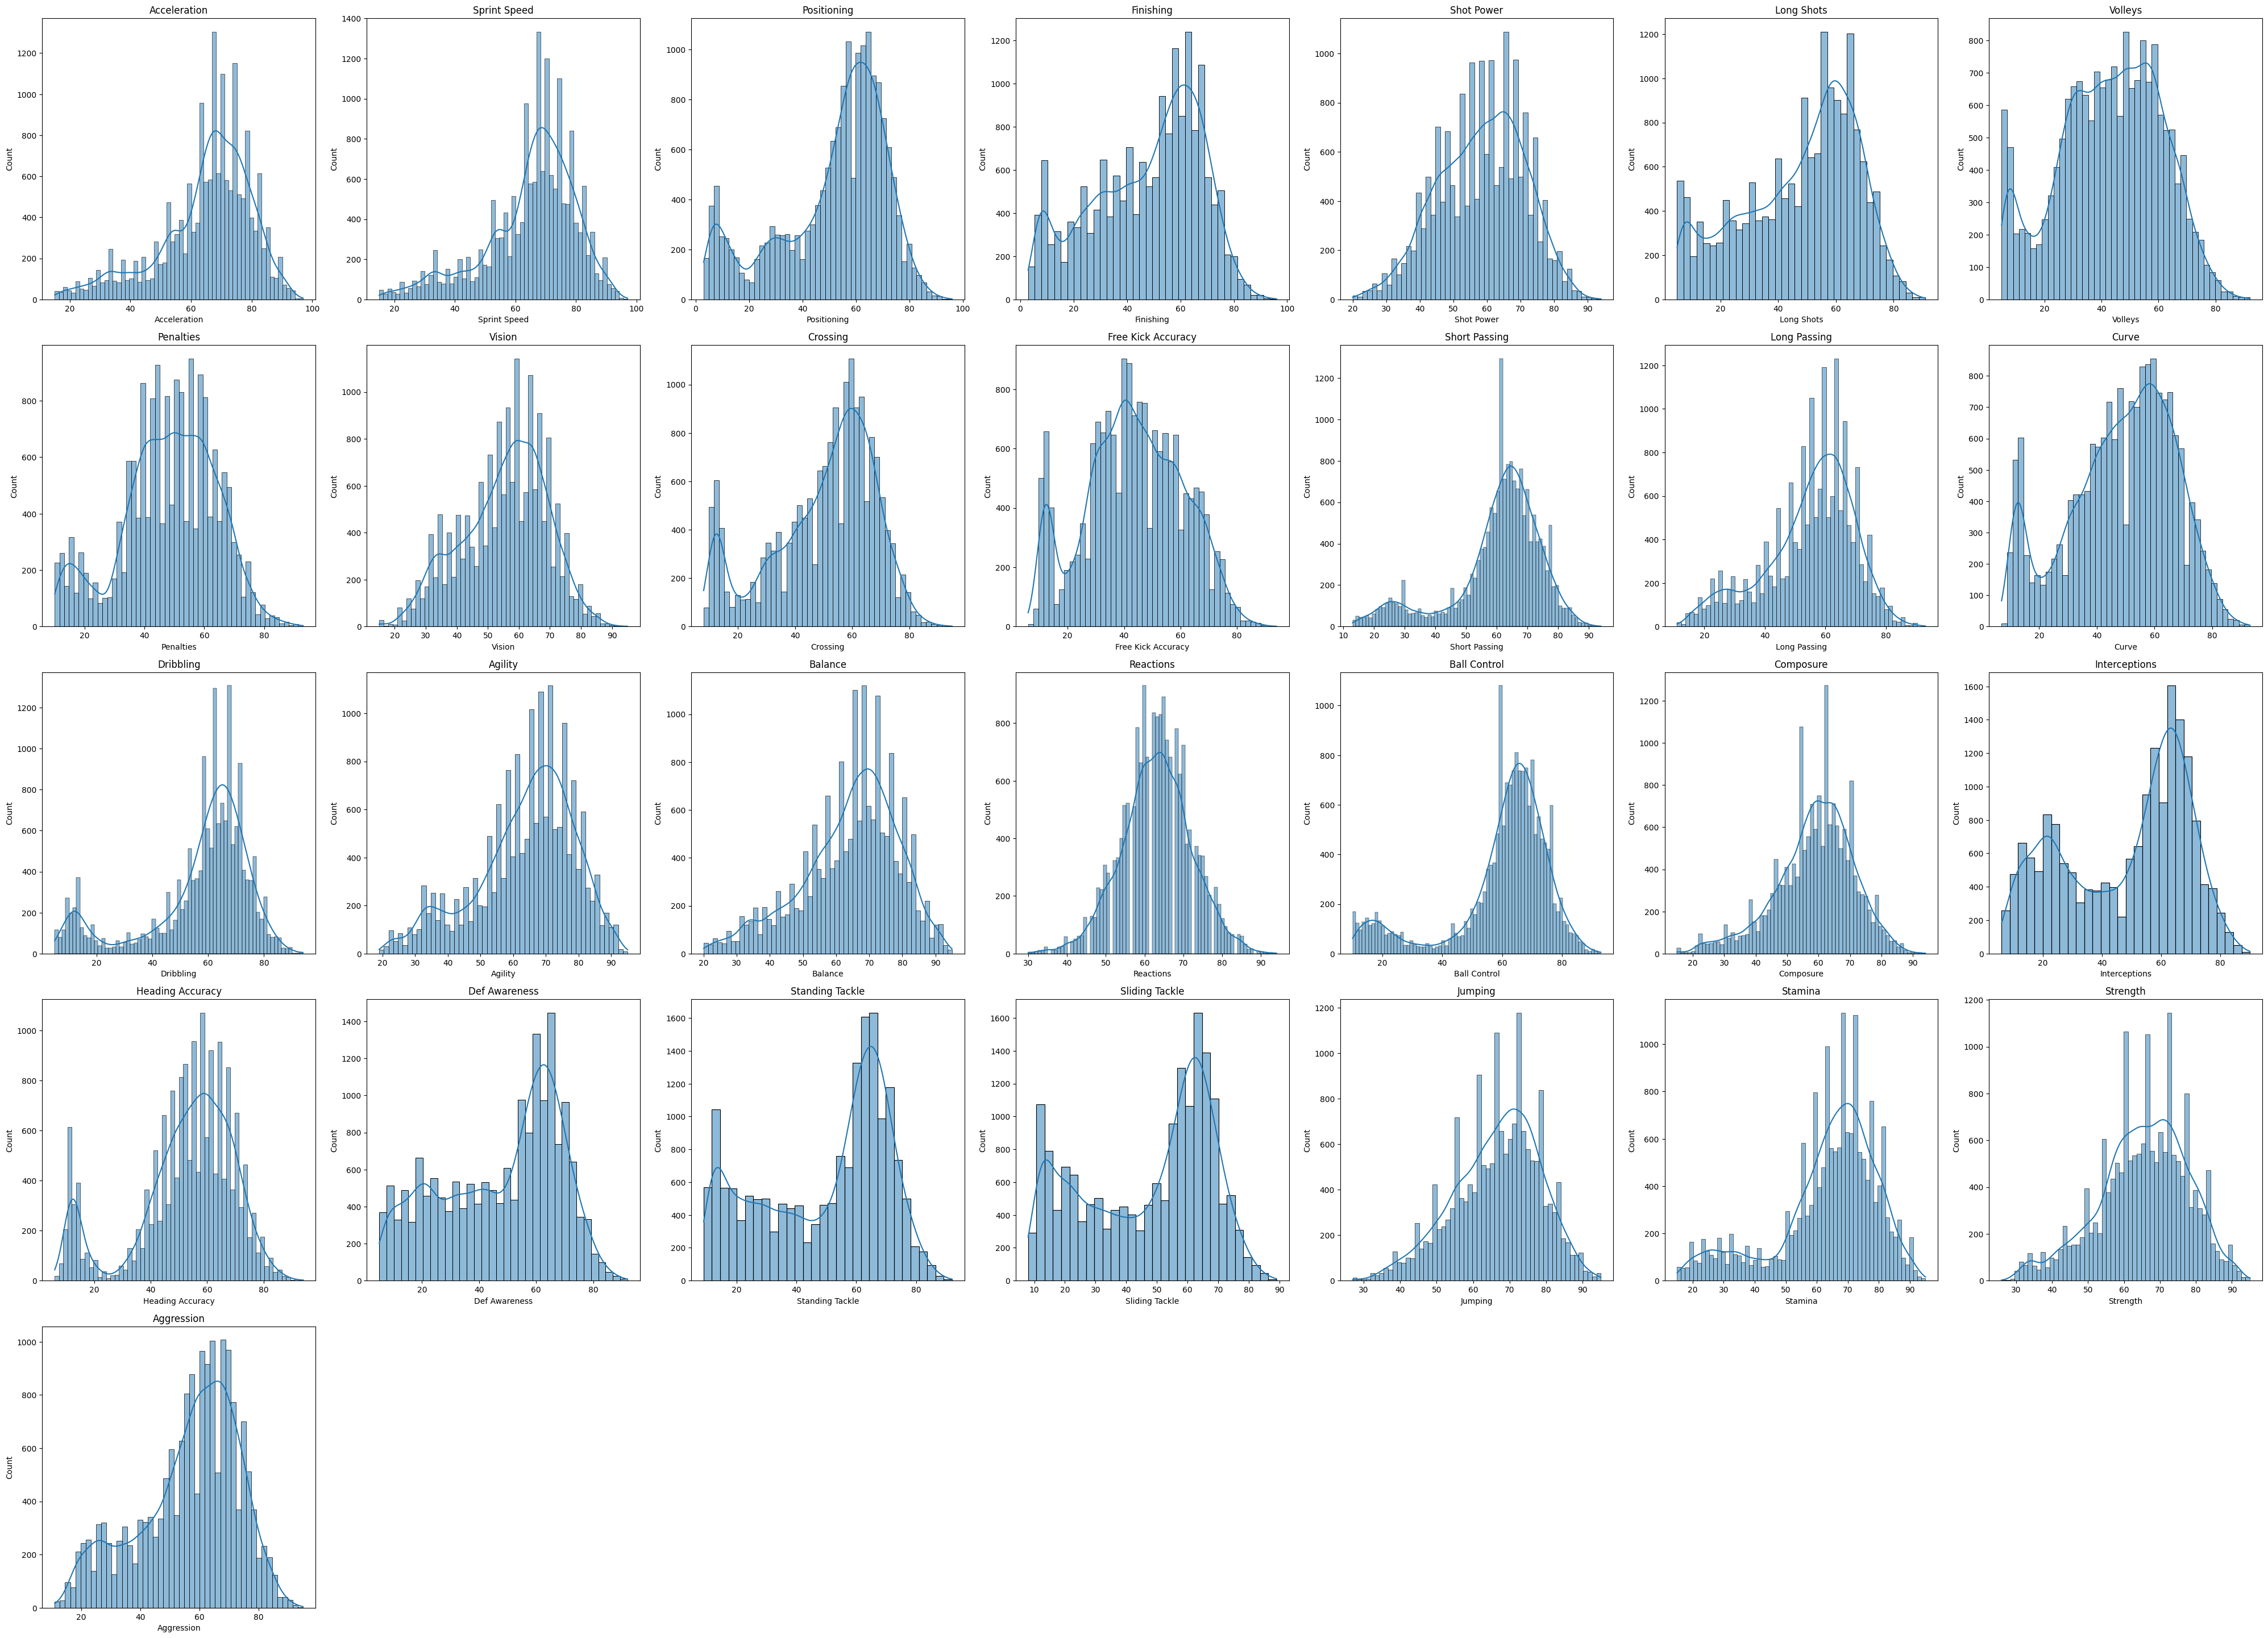

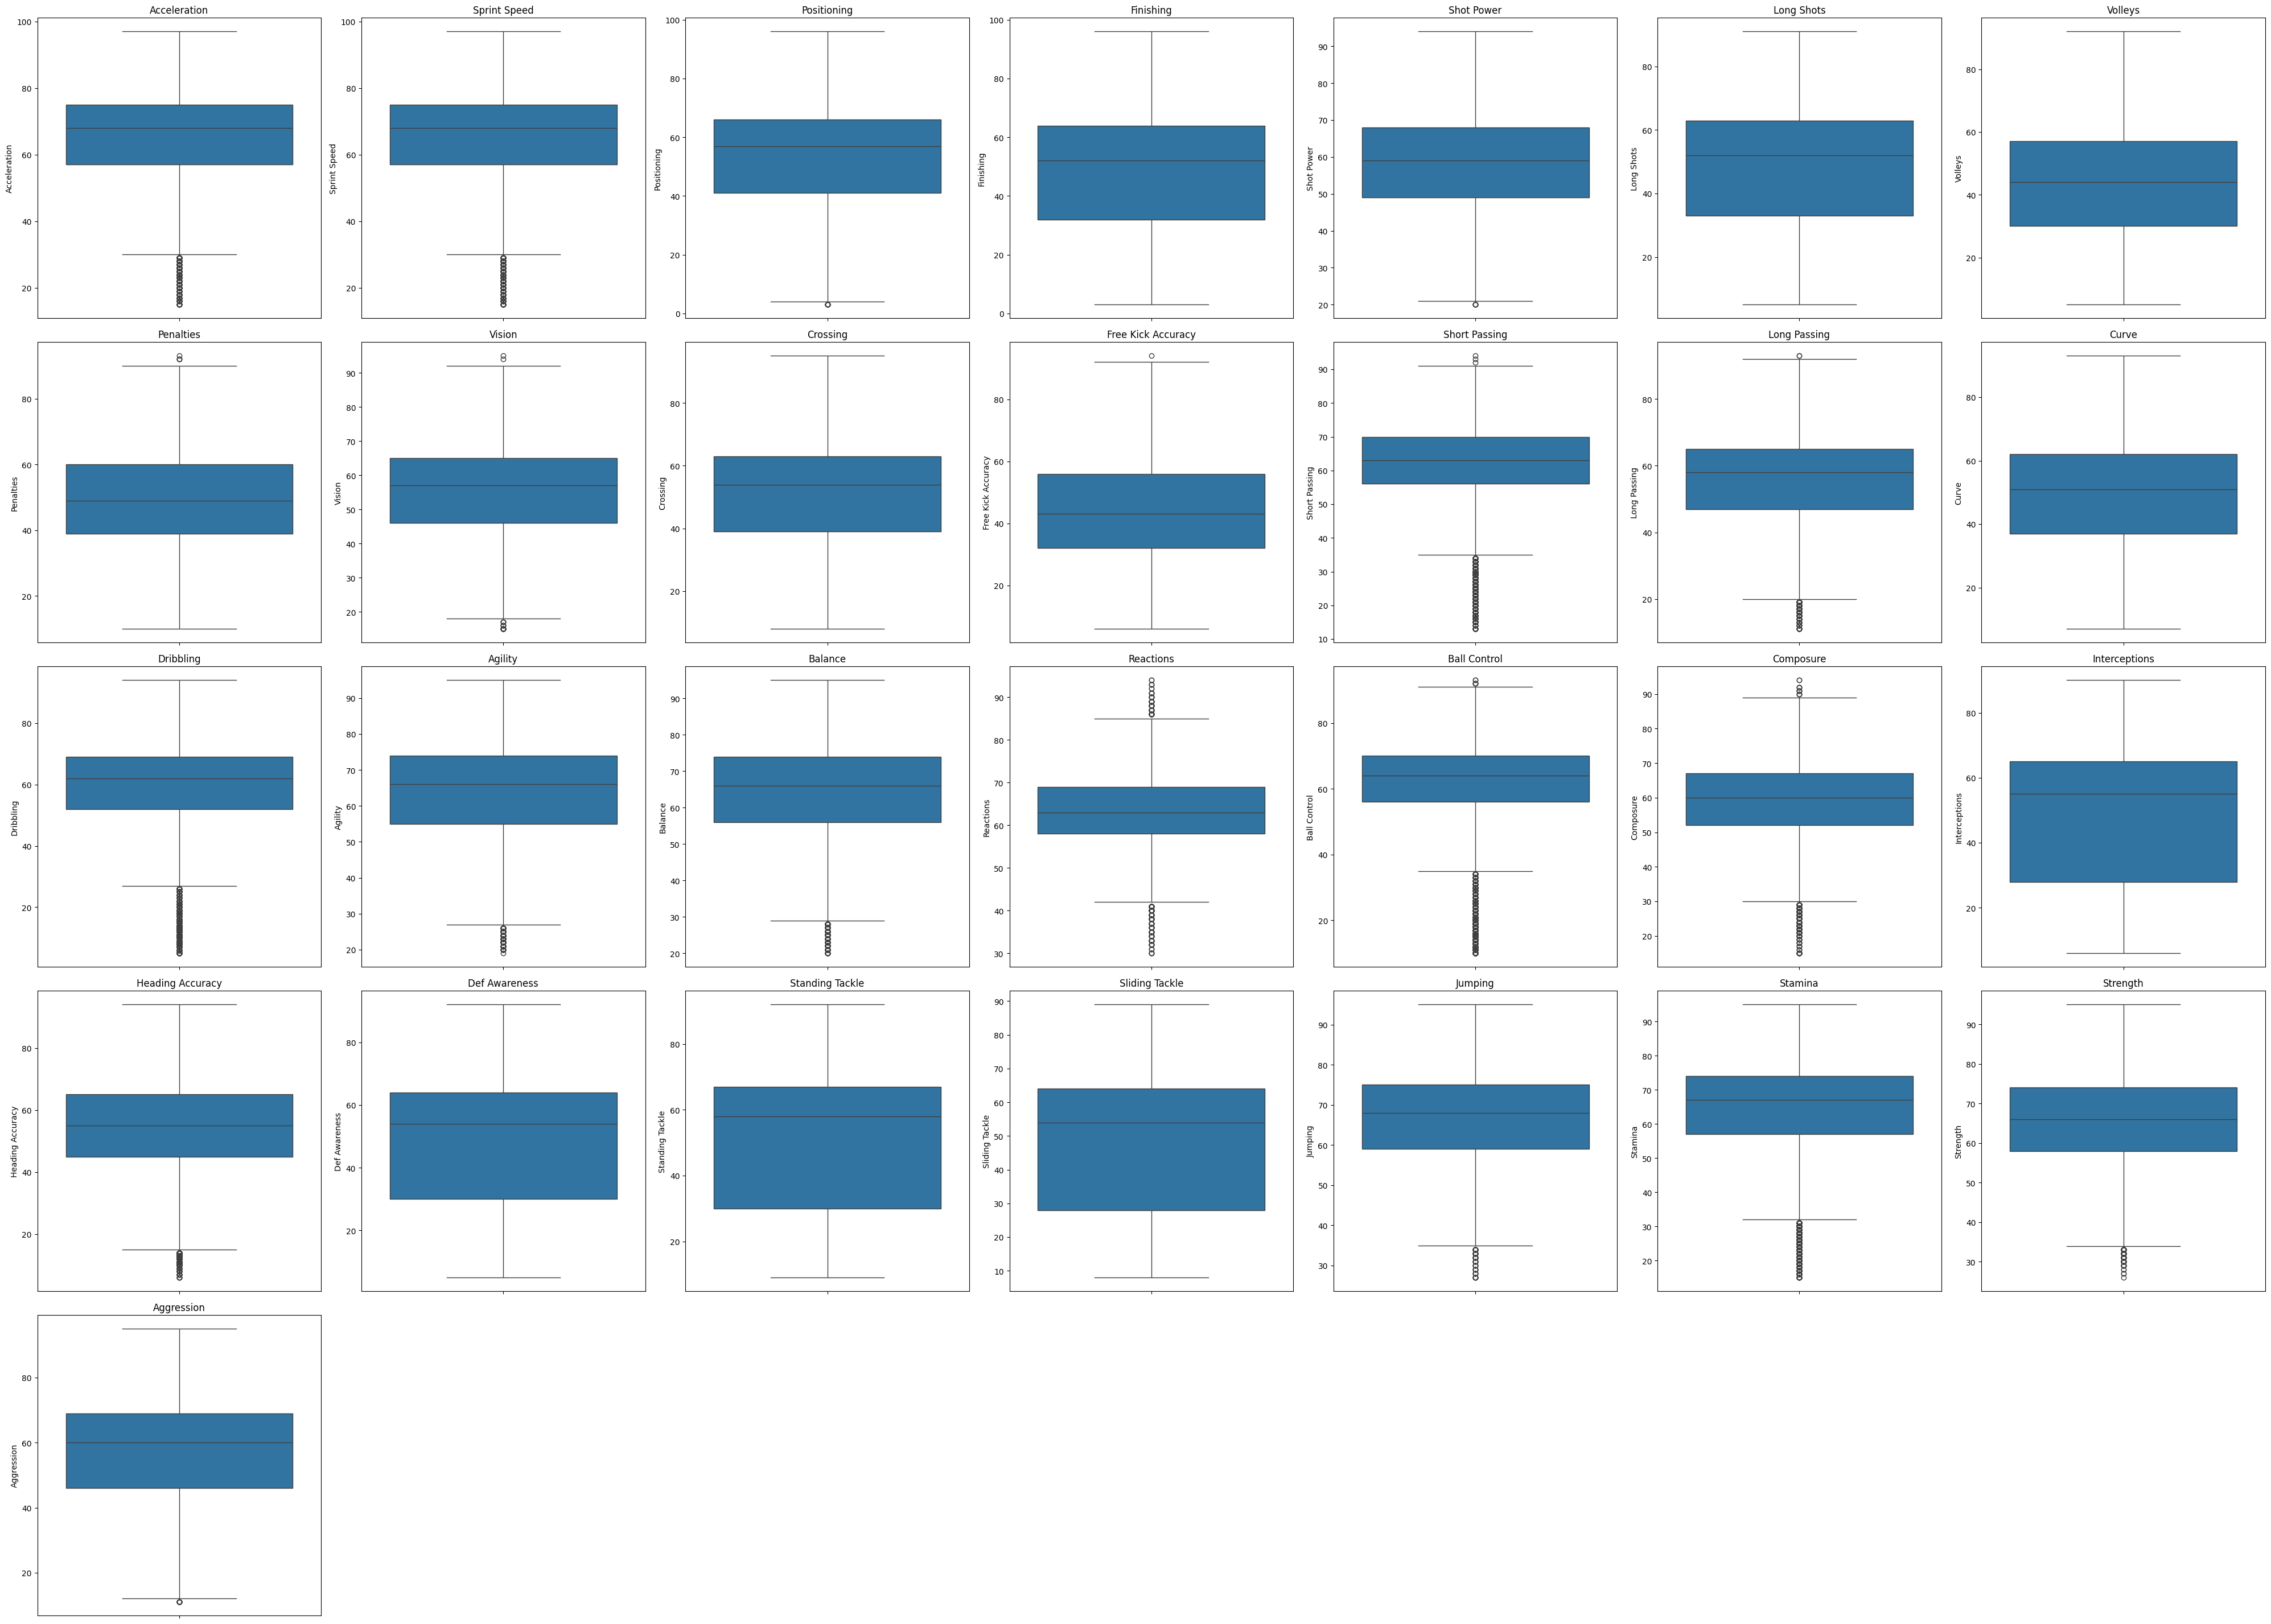

In [98]:
# Lendo os dados obtidos já baixados da base de dados
dataset = pd.read_csv('all_players.csv', sep=',', decimal='.')

# Quantos jogadores existem no dataset?
print("Quantidade de jogadores na base de dados: ", len(dataset))

# Checando se há dados faltantes
if dataset.isna().sum().sum() > 0:
    print(f'Existem {dataset.isna().sum()} dados faltantes no dataset')
else:
    print("Não há dados faltantes no dataset.")

# Checando se há dados duplicados
if dataset.duplicated().sum().sum() > 0:
    print(f'Existem {dataset.duplicated().sum()} dados duplicados no dataset')
else:
    print("Não há dados duplicados no dataset.")


# Verificando os tipos de cada dado
print("Tipo de dados:")
print(dataset.dtypes)


# Selecionando as colunas com os atributos que desejo considerar 
atributos = [
    "Acceleration", "Sprint Speed", "Positioning", "Finishing", "Shot Power", "Long Shots",
    "Volleys", "Penalties", "Vision", "Crossing", "Free Kick Accuracy", "Short Passing",
    "Long Passing", "Curve", "Dribbling", "Agility", "Balance", "Reactions", "Ball Control",
    "Composure", "Interceptions", "Heading Accuracy", "Def Awareness", "Standing Tackle",
    "Sliding Tackle", "Jumping", "Stamina", "Strength", "Aggression"
] # Retirei colunas como age, height e weight, também tirei  "OVR", "PAC", "SHO", "PAS", "DRI", "DEF", "PHY". Além das não numéricas

dataset_atb = dataset[atributos]
plt.figure(figsize=(40, 40))

# Plotando um histograma
for index, value in enumerate(dataset_atb):
    plt.subplot(7, 7, index + 1)
    sns.histplot(dataset[value], kde=True)
    plt.title(value)
plt.tight_layout()

# Plotando um boxplot
plt.figure(figsize=(40,40))
for index, column in enumerate(dataset_atb):
    plt.subplot(7, 7, index+1)
    sns.boxplot(dataset[column])
    plt.title(column)
plt.tight_layout()

# Calculando a faixa dinâmica para cada atributo
print("\nFaixa dinâmica (valor máximo - valor mínimo) para cada atributo:")
faixa_dinamica = dataset_atb.max() - dataset_atb.min()
print(faixa_dinamica)


Quero analisar os pontos fortes e fracos de um jogador para separar eles em posições, e não ser influenciado pela "qualidade" do jogador. Portanto, vou modificar todos os atributos para serem a diferença entre ele mesmo e a média dos atributos desse determinado jogador. Escolhi a diferença e não a proporção pois acredito que isso vai potencializar as características positivas e negativas do jogador em questão.

Em testes iniciais sem essa etapa, um dos meus clusters era formado por "jogadores excelentes" e outro por "jogadores péssimos", sem diferenciação de posição

In [99]:
# Calculando a média de cada jogador (talvez pudesse usar o OVR do jogador, mas não tenho certeza como a produtora chega nesse número)
linha_media = dataset_atb.mean(axis=1)

# Subtraindo a média de cada linha
dataset_transformado = dataset_atb.sub(linha_media, axis=0)

# Exibindo o dataset transformado
print(dataset_transformado)

       Acceleration  Sprint Speed  Positioning  Finishing  Shot Power  \
0         19.413793     19.413793    15.413793  16.413793   12.413793   
1        -16.068966    -15.068966    -5.068966  -7.068966   10.931034   
2          3.620690     17.620690    19.620690  19.620690   17.620690   
3         -1.241379     -2.241379     8.758621   7.758621    2.758621   
4         22.482759     22.482759    14.482759  16.482759    8.482759   
...             ...           ...          ...        ...         ...   
17732     -1.655172     -4.655172    12.344828  13.344828   12.344828   
17733      4.551724      5.551724     3.551724   8.551724   13.551724   
17734      3.206897      7.206897    -3.793103   0.206897   16.206897   
17735      8.655172     10.655172     3.655172   2.655172    6.655172   
17736      9.517241     10.517241    -3.482759  -6.482759    8.517241   

       Long Shots    Volleys  Penalties     Vision   Crossing  ...  Composure  \
0        5.413793   6.413793   6.413793   

Devido à alta dimensionalidade da minha base de dados (29 atributos diferentes sendo considerado) vou tentar avaliar a correlação entre eles na expectativa de conseguir diminuir o tamanho. Pretendo evitar utilizar PCA pois é importante para mim que os atributos médios de um cluster tenham um valor semântico que me permita identificar a posição dos jogadores deste cluster

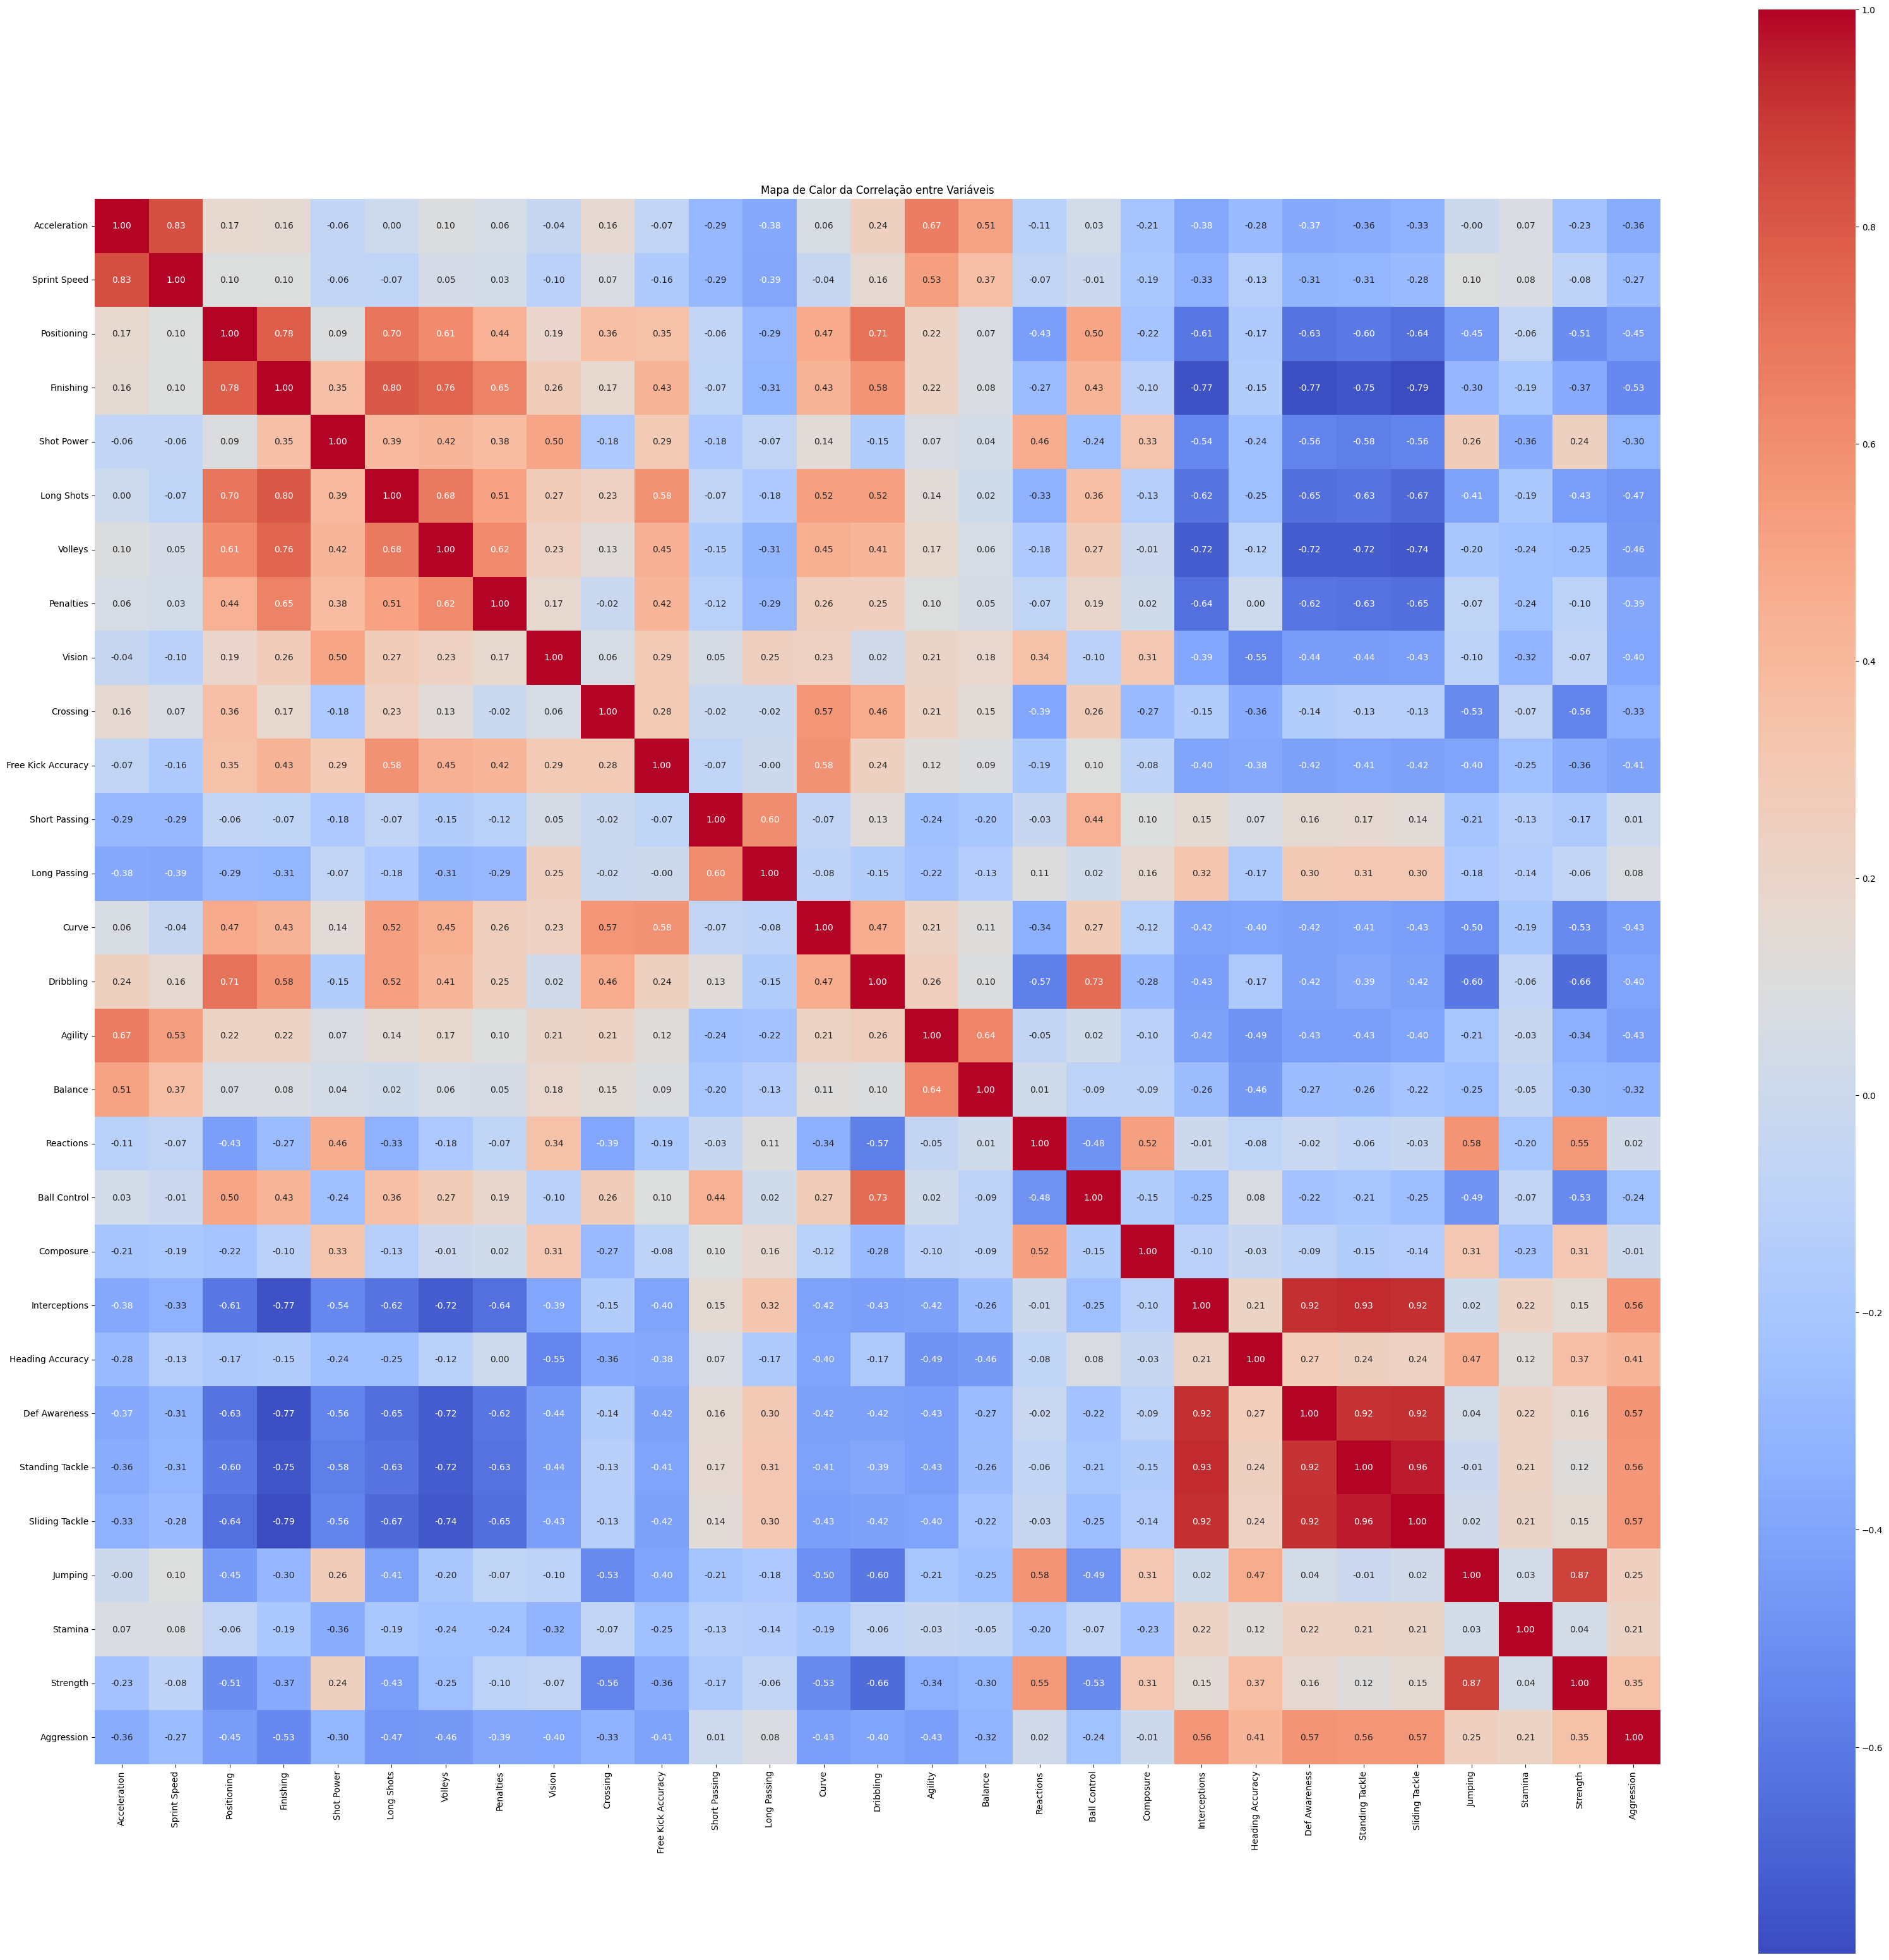

Correlações acima de limite_de_correlacao:
          Variável 1       Variável 2  Correlação
299   Sliding Tackle  Standing Tackle    0.963292
273  Standing Tackle    Interceptions    0.933095
296   Sliding Tackle    Interceptions    0.921273
251    Def Awareness    Interceptions    0.920820
298   Sliding Tackle    Def Awareness    0.917665
275  Standing Tackle    Def Awareness    0.915614


In [100]:
# Atualizando o dataset_atb para conter essa transformação que realizei
dataset_atb=dataset_transformado

# Gerando a matriz de correlação
matriz_correlacao = dataset_atb.corr()

# Exibindo o mapa de calor
plt.figure(figsize=(40, 40))
sns.heatmap(matriz_correlacao, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title('Mapa de Calor da Correlação entre Variáveis')
plt.show()

# Gerando uma tabela com as variáveis mais correlacionadas
# Criando uma lista para armazenar as variáveis e suas correlações
dataframe_correlacao = []

for i in range(len(matriz_correlacao.columns)):
    for j in range(i):
        dataframe_correlacao.append({
            'Variável 1': matriz_correlacao.columns[i],
            'Variável 2': matriz_correlacao.columns[j],
            'Correlação': matriz_correlacao.iloc[i, j]
        })

# Criando um DataFrame para exibir as correlações mais altas
dataframe_correlacao = pd.DataFrame(dataframe_correlacao)

# Filtrando apenas as correlações com valor maior que o limite estipulado
limite_de_correlacao=0.9
atb_relacionados = dataframe_correlacao[dataframe_correlacao['Correlação'] > limite_de_correlacao]

# Exibindo as correlações acima do limite estipulado
print(f"Correlações acima de {'limite_de_correlacao'}:")
print(atb_relacionados.sort_values(by='Correlação', ascending=False)) 


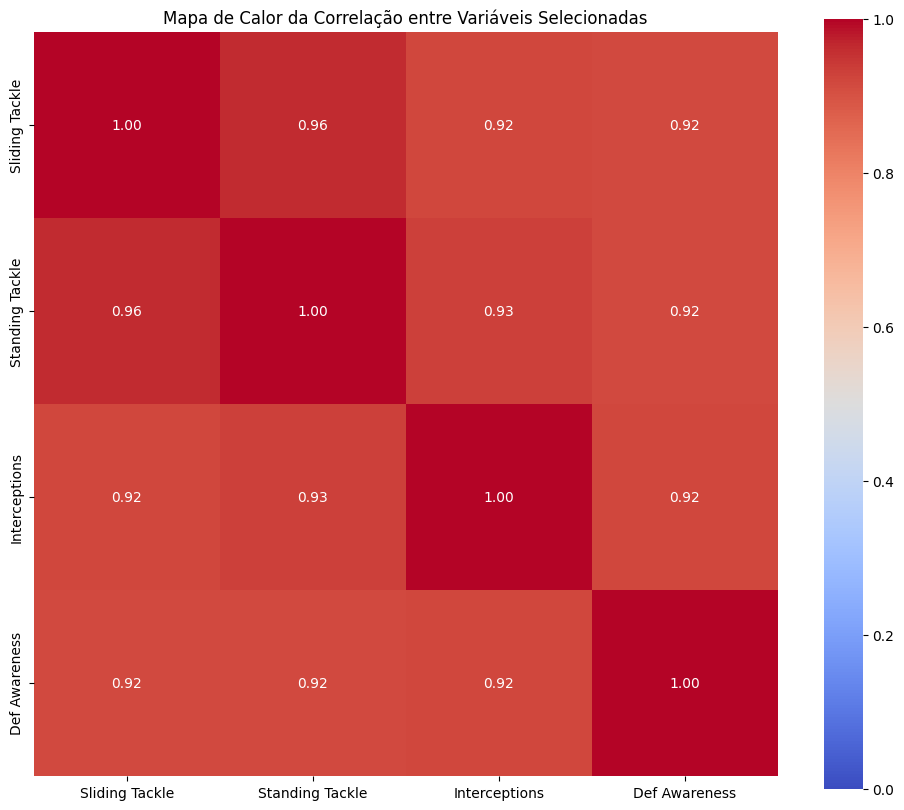

In [101]:
variaveis_selecionadas = [
    "Sliding Tackle", "Standing Tackle", "Interceptions", 
    "Def Awareness"   
]

# Filtrando o DataFrame para manter apenas as variáveis selecionadas
matrix_variaveis_selecionadas = dataset_atb[variaveis_selecionadas].corr()

# Gerando o mapa de calor indo de 0 a 1 independente das amostras (caso contrario alguns 9.2 estariam em azul)
plt.figure(figsize=(12, 10))
sns.heatmap(matrix_variaveis_selecionadas, annot=True, cmap="coolwarm", fmt=".2f", square=True, vmin=0, vmax=1)
plt.title('Mapa de Calor da Correlação entre Variáveis Selecionadas')
plt.show()

Dessa forma, decidi que agruparia esses 4 atributos em um geral, chamado "General Def"

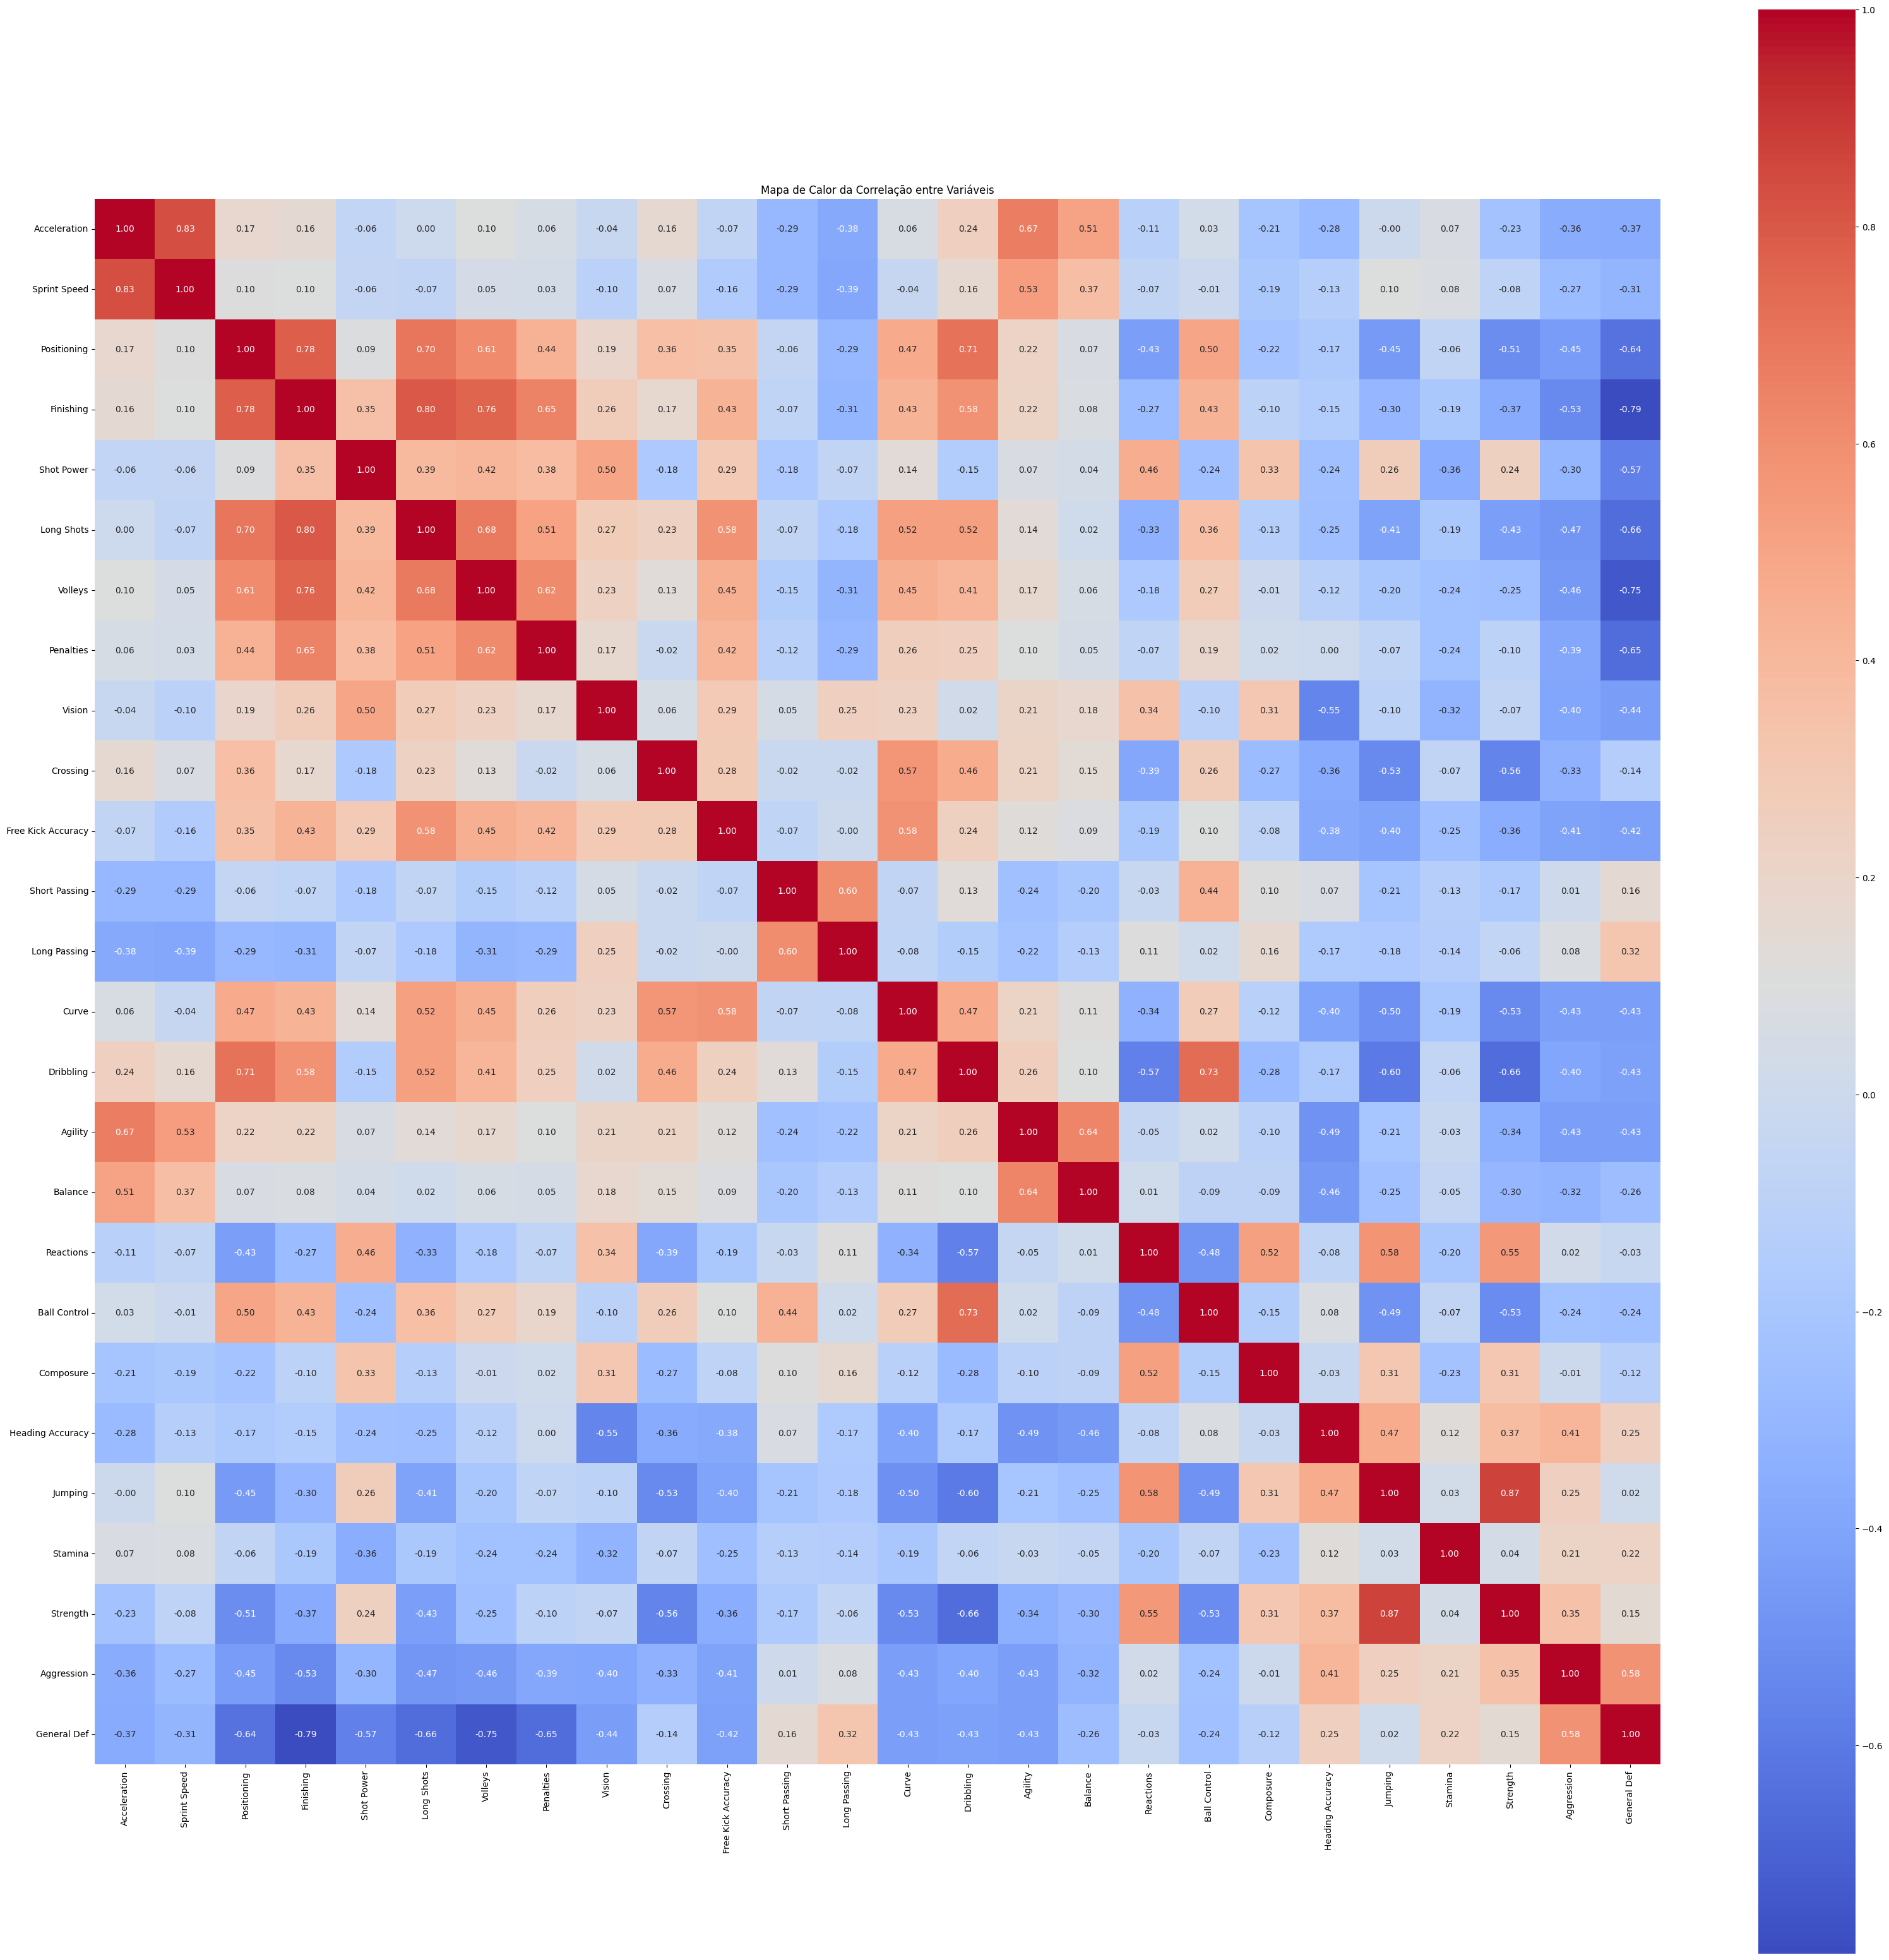

In [102]:
# Criando um novo dataset com a quantidade de atributos reduzida
dataset_atb_reduzida = dataset_atb.copy()

# Criando uma nova coluna de atributo com o nome "General Def" e o valor médio dos atributos que a compõem
dataset_atb_reduzida.loc[:, "General Def"] = dataset_atb[["Sliding Tackle", "Standing Tackle", "Interceptions", "Def Awareness"]].mean(axis=1)

# Retirando as colunas redundantes do novo dataset
dataset_atb_reduzida.drop(columns=["Sliding Tackle", "Standing Tackle", "Interceptions", "Def Awareness"], inplace=True)

# Gerando a nova matriz de correlação
correlation_matrix = dataset_atb_reduzida.corr()

# Exibindo o mapa de calor
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title('Mapa de Calor da Correlação entre Variáveis')
plt.show()

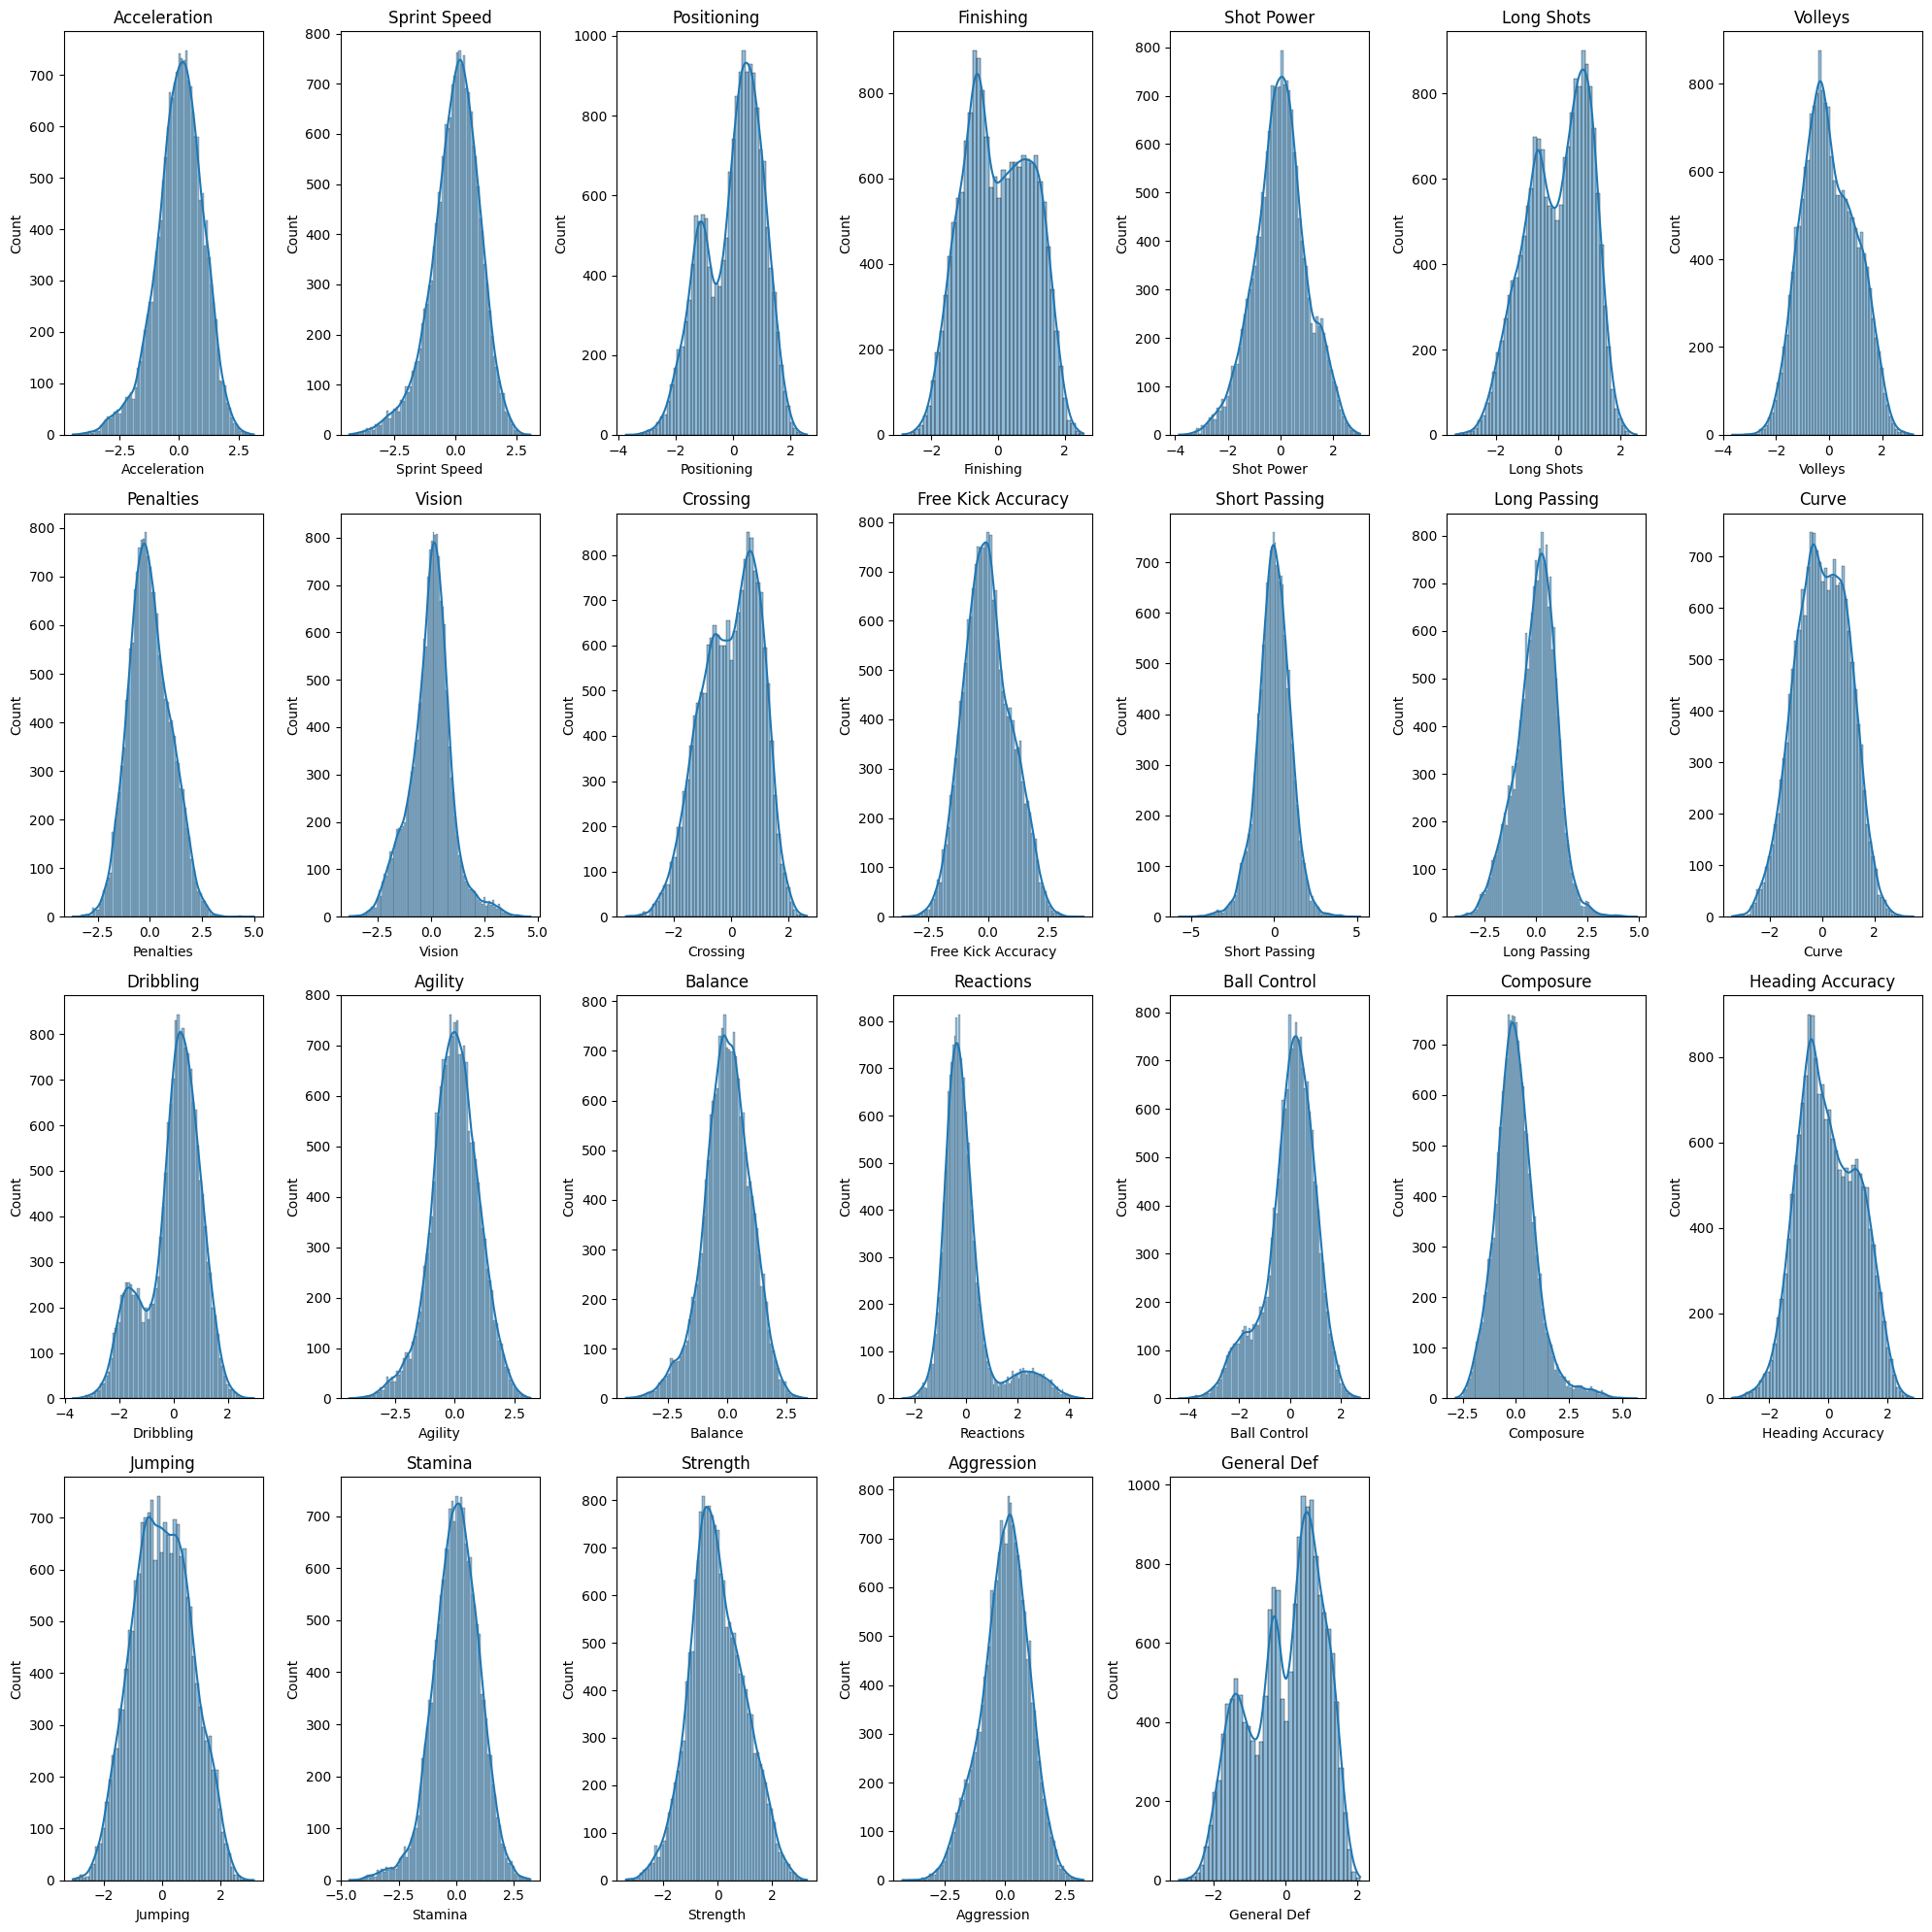

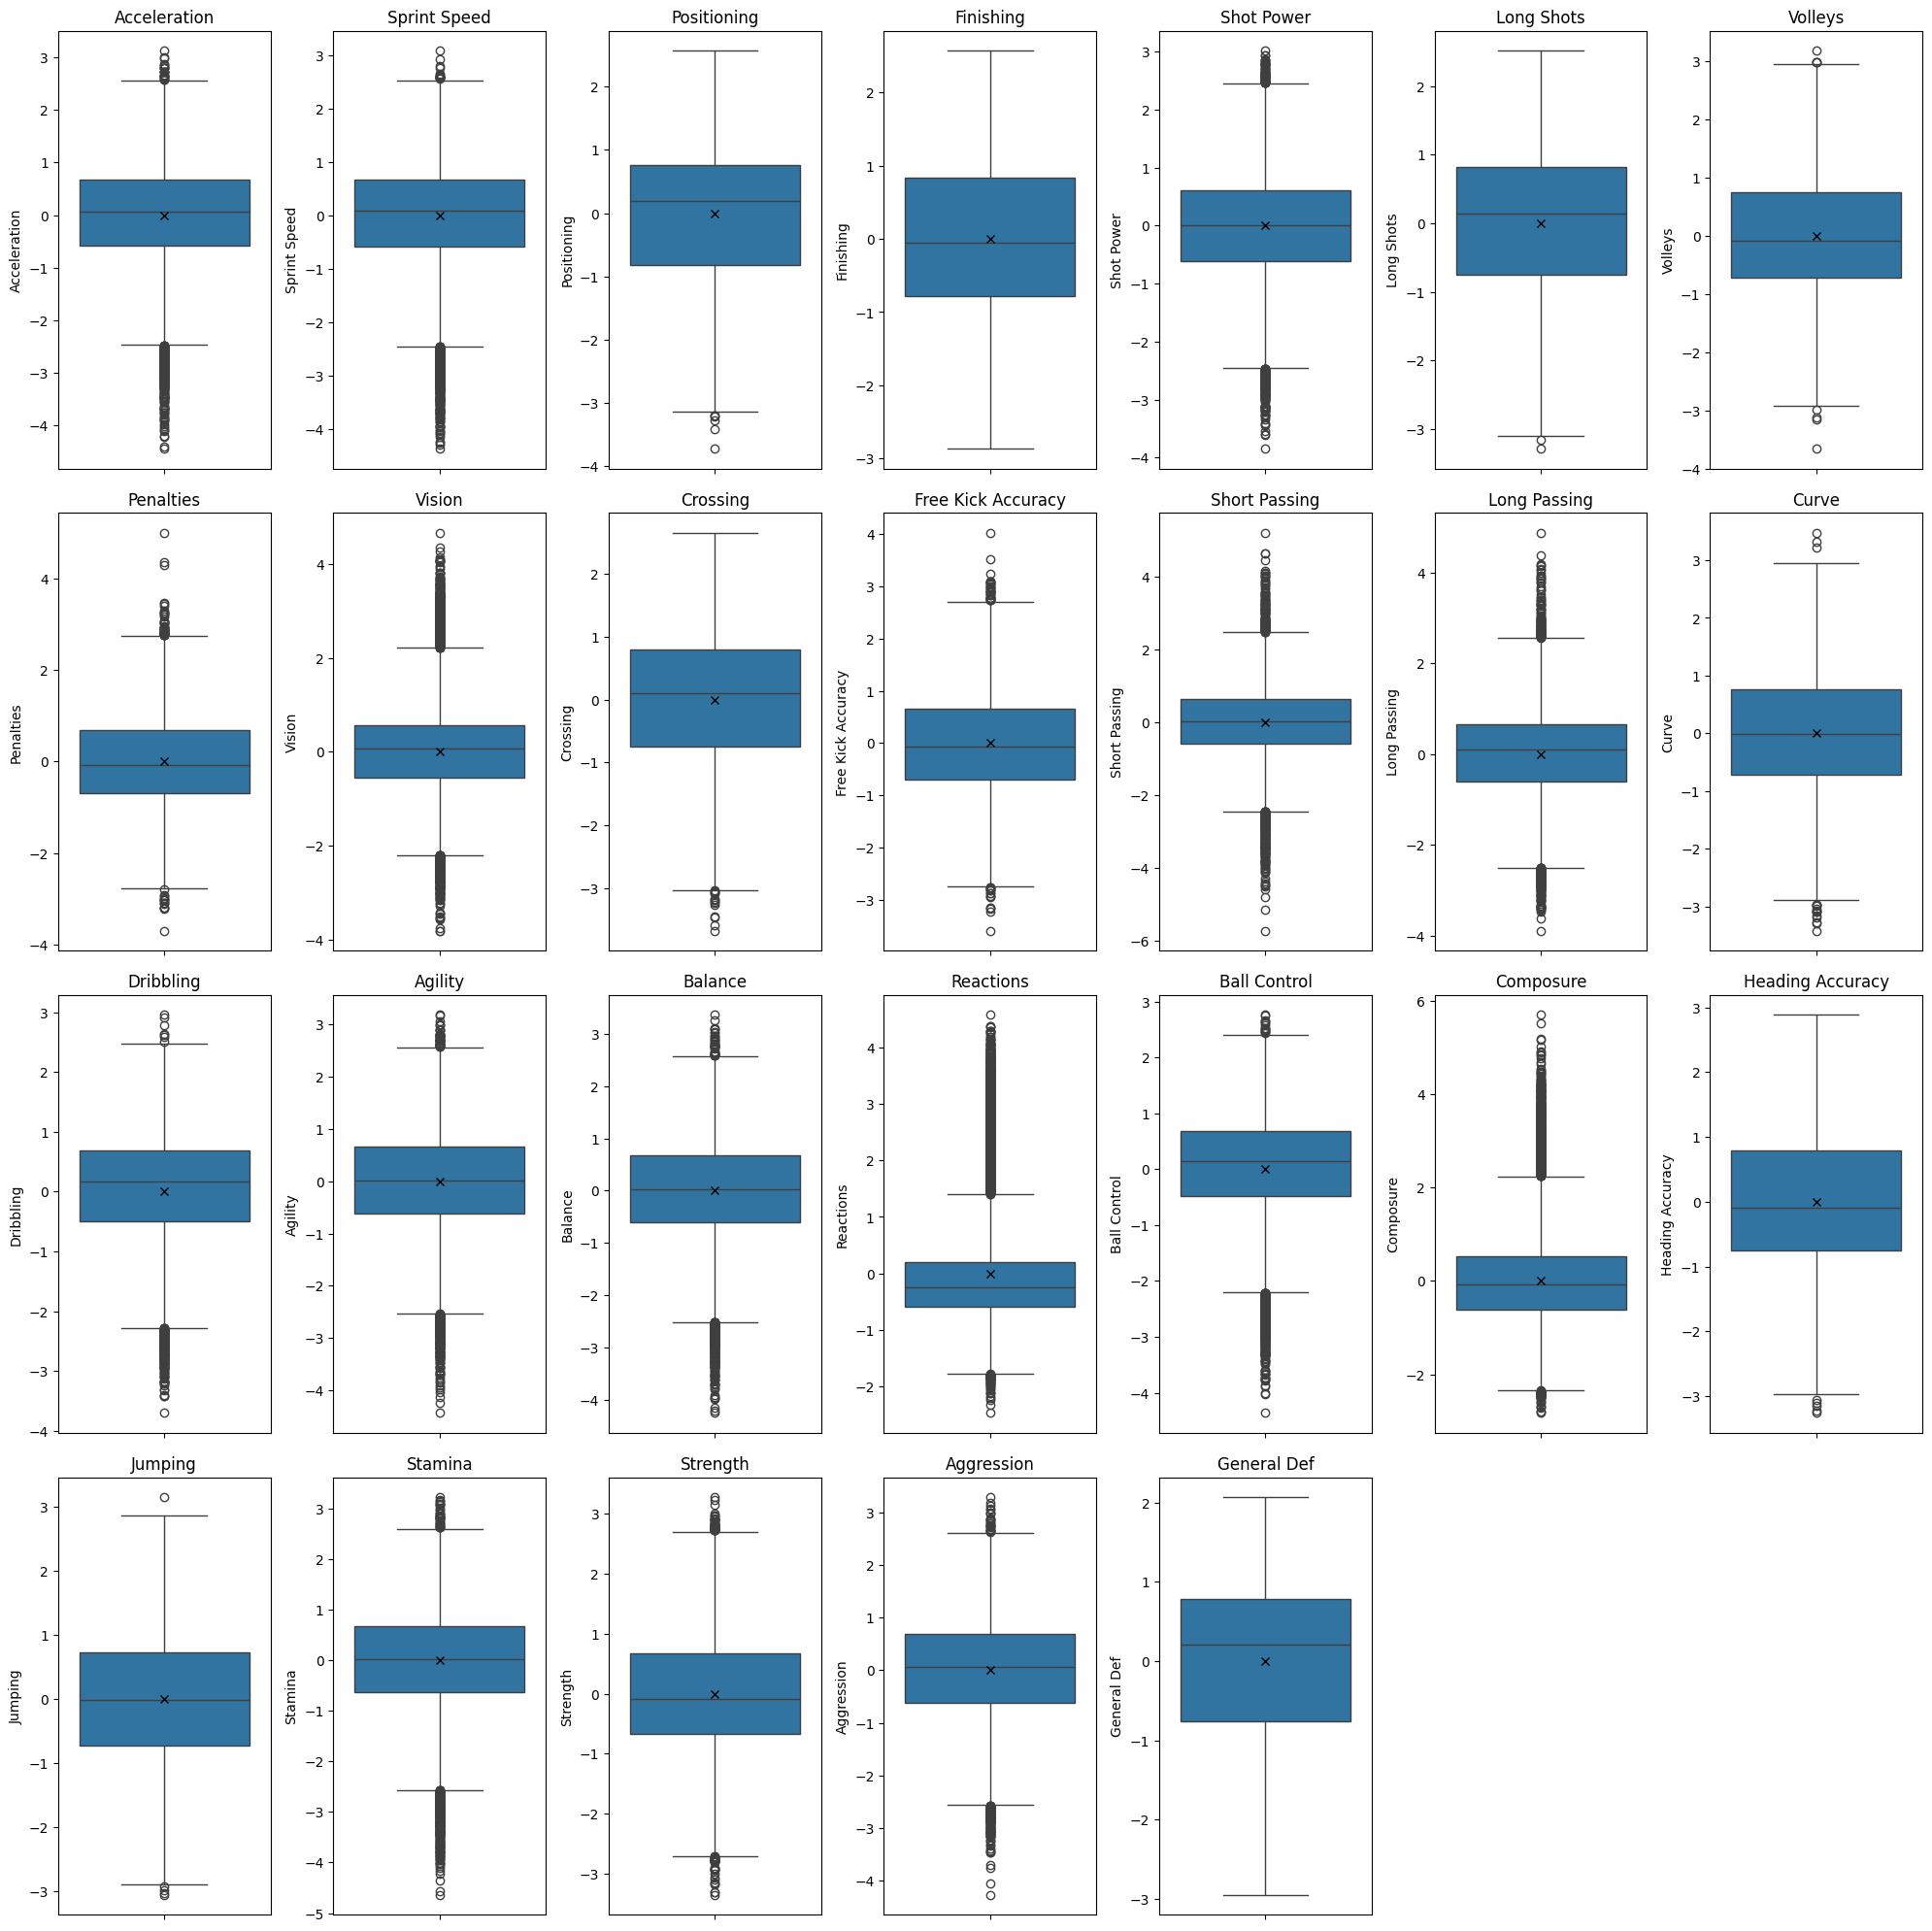

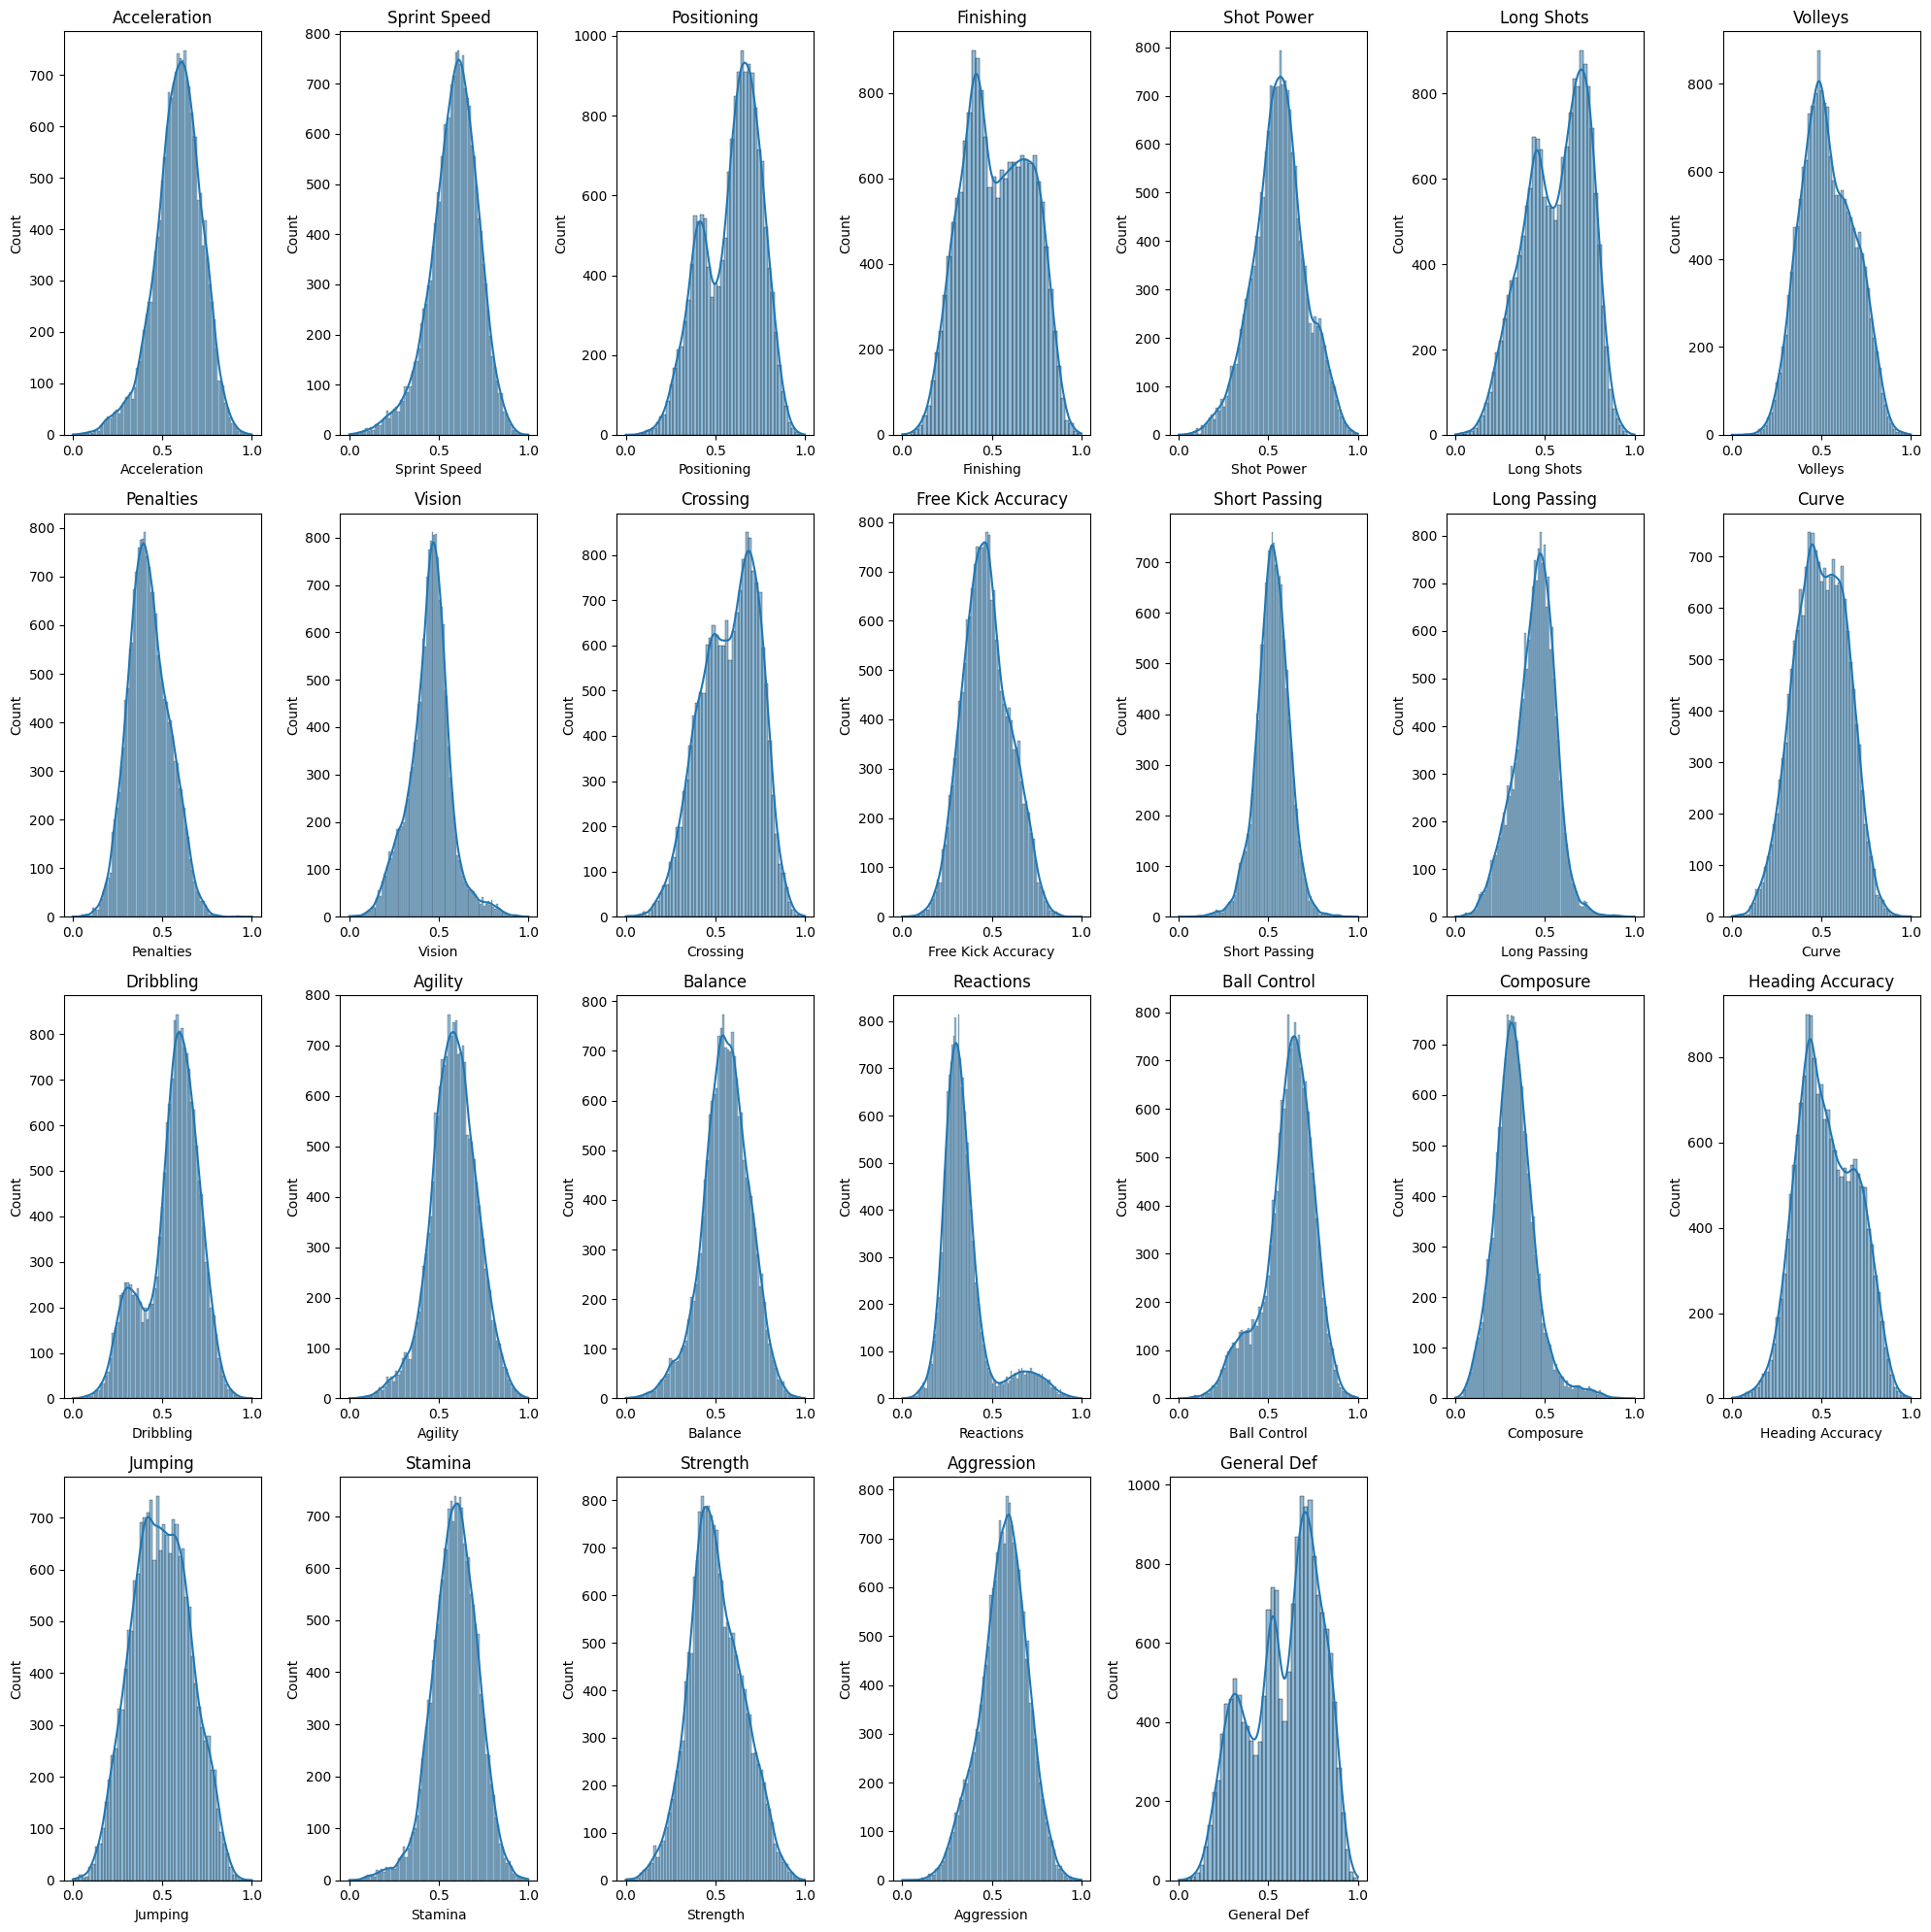

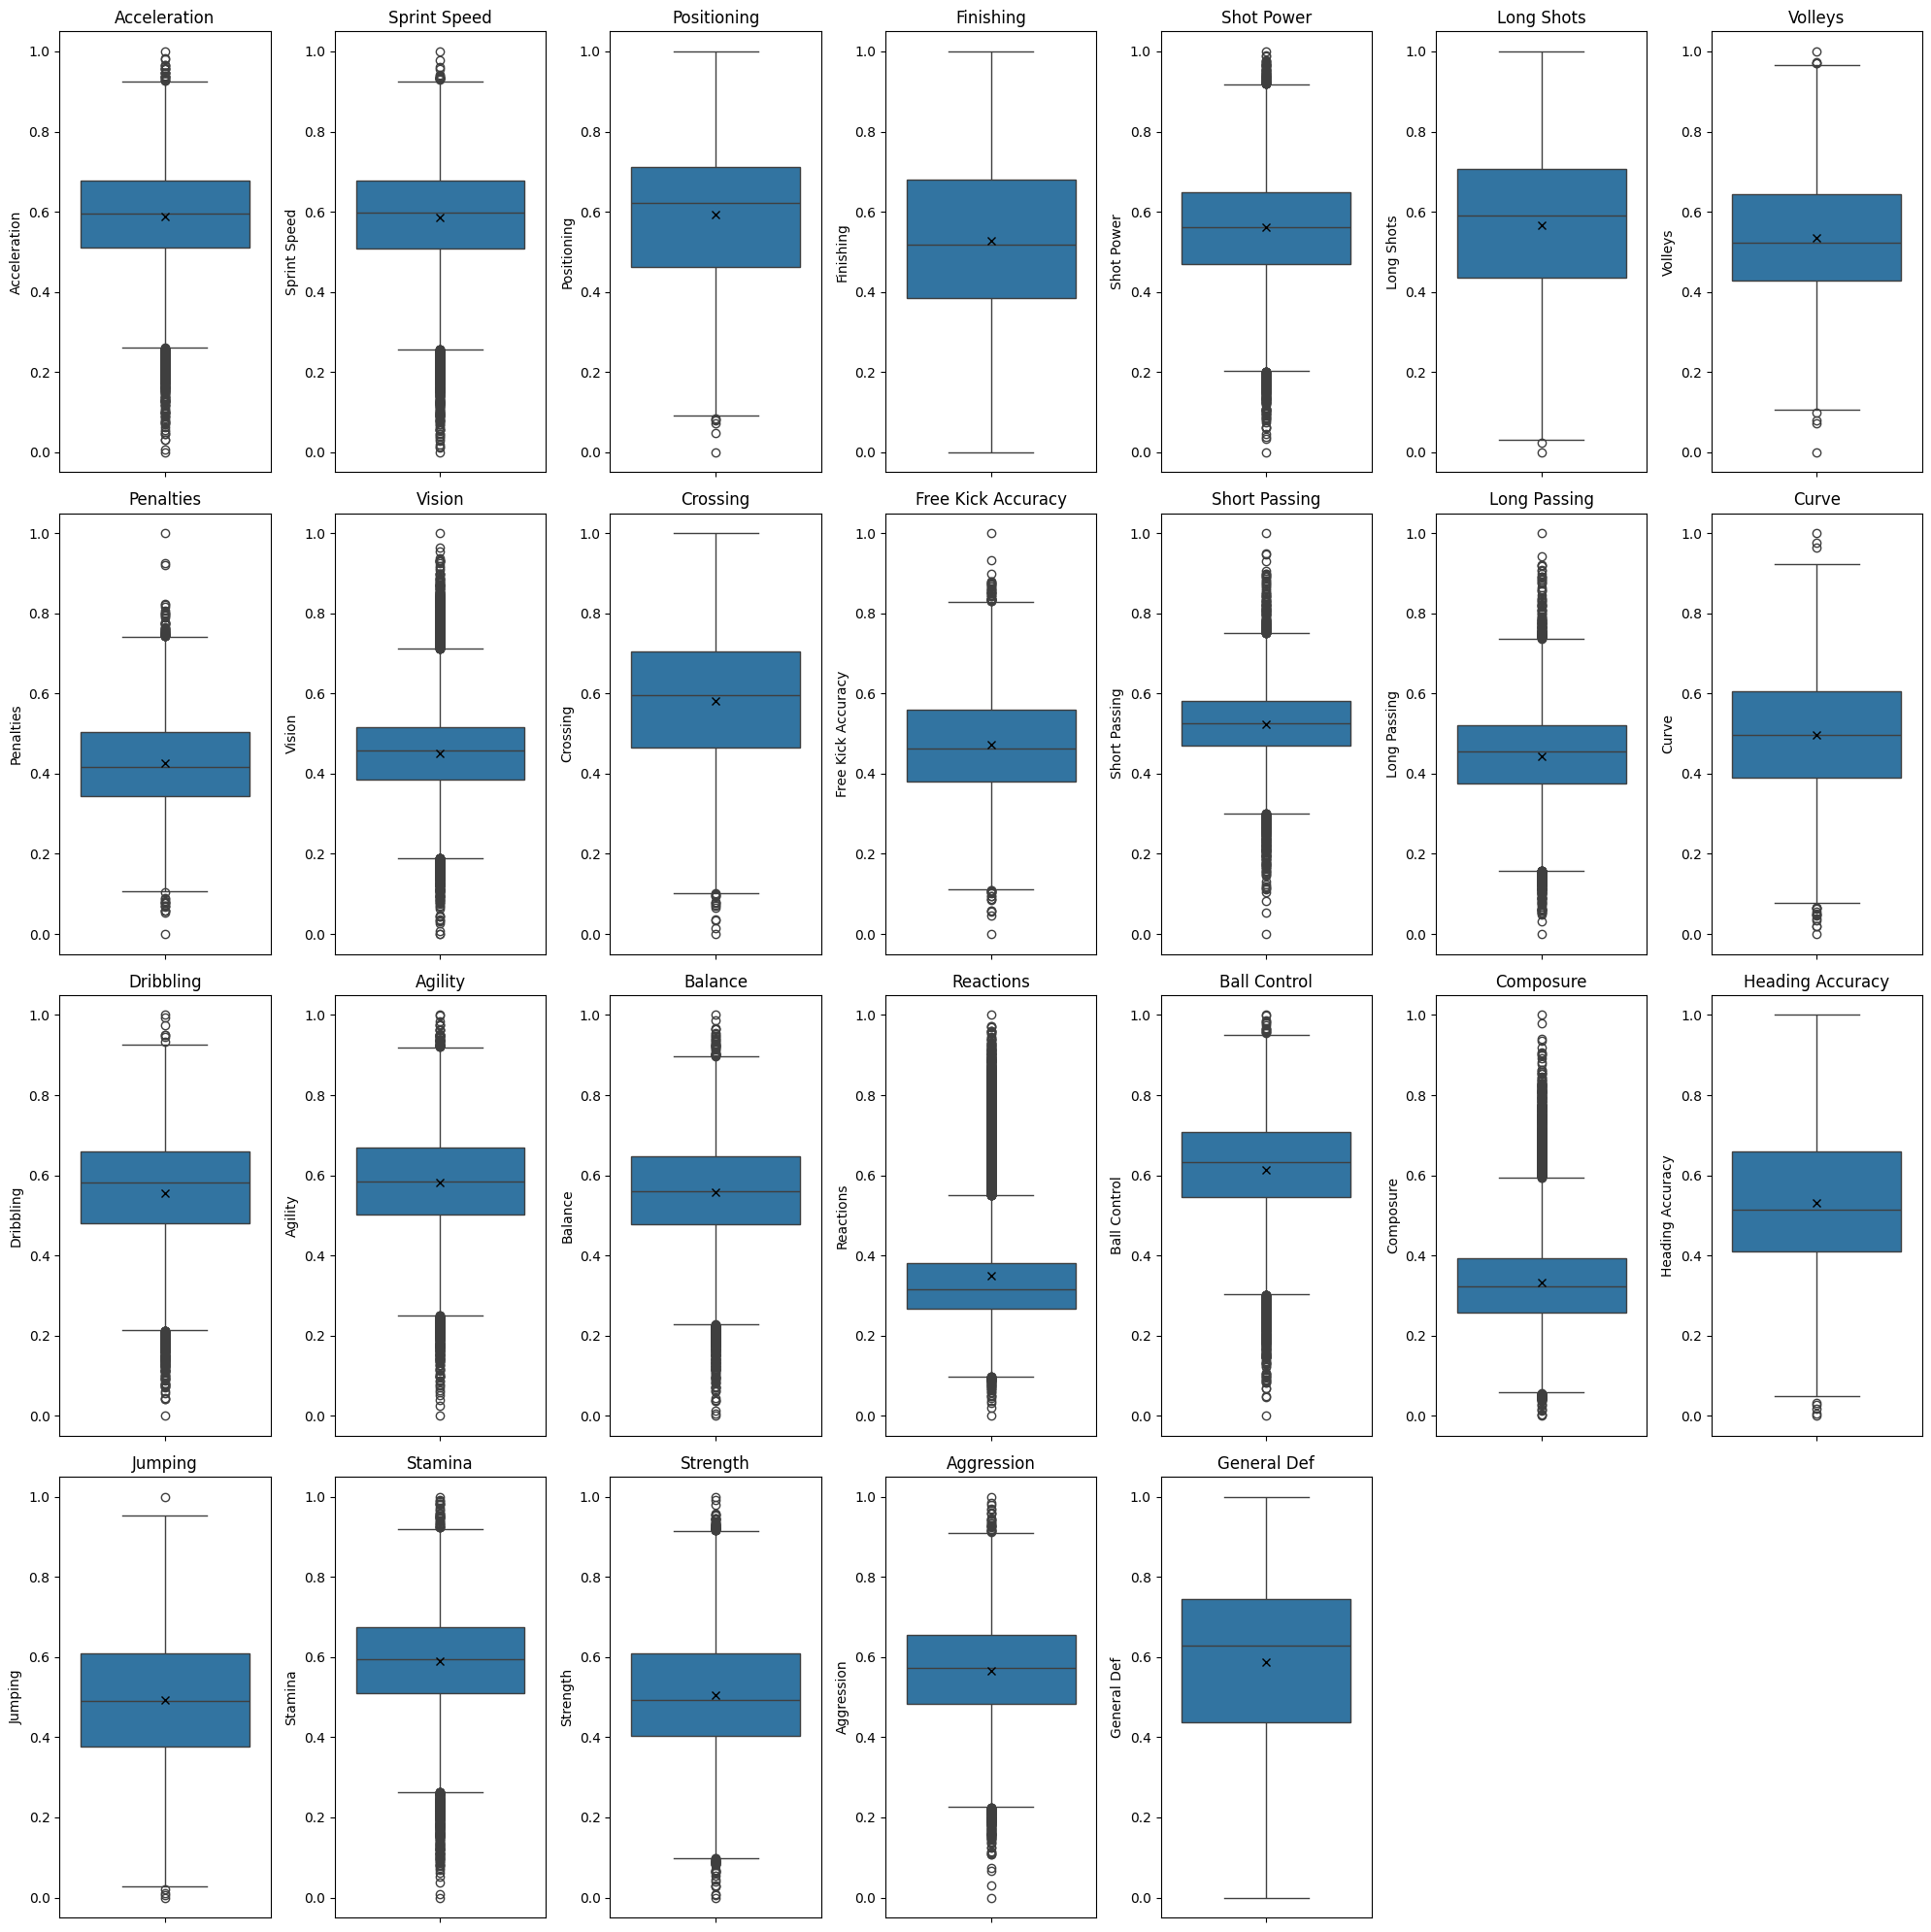

In [103]:
# utilizando o dataset reduzido, fiz tanto StandartScale quanto MinMaxScaler para observar qual teria o melhor resultado.

dataset_escolhido=dataset_atb_reduzida.copy()

scaler_ss = sklearn.preprocessing.StandardScaler()
scaler_ss.fit(dataset_escolhido)
dataset_tratado_ss = scaler_ss.transform(dataset_escolhido)

# Nomeando as colunas do dataset tratado
dataset_tratado_ss = pd.DataFrame(dataset_tratado_ss, columns=dataset_escolhido.columns)

# Plotando os histogramas
n_cols = len(dataset_tratado_ss.columns)
n_rows = (n_cols // 7) + (1 if n_cols % 7 != 0 else 0)  # Calcular o número de linhas necessárias

plt.figure(figsize=(20, 20))
for index, value in enumerate(dataset_tratado_ss.columns):
    plt.subplot(n_rows, 7, index + 1)  # Ajustando o layout para o número correto de subgráficos
    sns.histplot(dataset_tratado_ss[value], kde=True)
    plt.title(value)
plt.tight_layout()

# Plotando os boxplots
plt.figure(figsize=(20, 20))
for index, column in enumerate(dataset_tratado_ss.columns):
    plt.subplot(n_rows, 7, index + 1)
    sns.boxplot(data=dataset_tratado_ss[column], showmeans=True, meanprops={"marker": "x", "markeredgecolor": "black"})
    plt.title(column)
plt.tight_layout()

# Aplicando MinMaxScaler
scaler_mm = sklearn.preprocessing.MinMaxScaler()
scaler_mm.fit(dataset_escolhido)
dataset_tratado_mm = scaler_mm.transform(dataset_escolhido)

# Nomeando as colunas do dataset tratado
dataset_tratado_mm = pd.DataFrame(dataset_tratado_mm, columns=dataset_escolhido.columns)

# Plotando os histogramas para o MinMaxScaler
plt.figure(figsize=(20, 20))
for index, value in enumerate(dataset_tratado_mm.columns):
    plt.subplot(n_rows, 7, index + 1)
    sns.histplot(dataset_tratado_mm[value], kde=True)
    plt.title(value)
plt.tight_layout()

# Plotando os boxplots para o MinMaxScaler
plt.figure(figsize=(20, 20))
for index, column in enumerate(dataset_tratado_mm.columns):
    plt.subplot(n_rows, 7, index + 1)
    sns.boxplot(data=dataset_tratado_mm[column], showmeans=True, meanprops={"marker": "x", "markeredgecolor": "black"})
    plt.title(column)
plt.tight_layout()

## Parte 3 - CLUSTERIZACAO

Agora vou começar a clusterização, inicialmente pelo K-means

Utilizando o dataset tratado com StandartScale


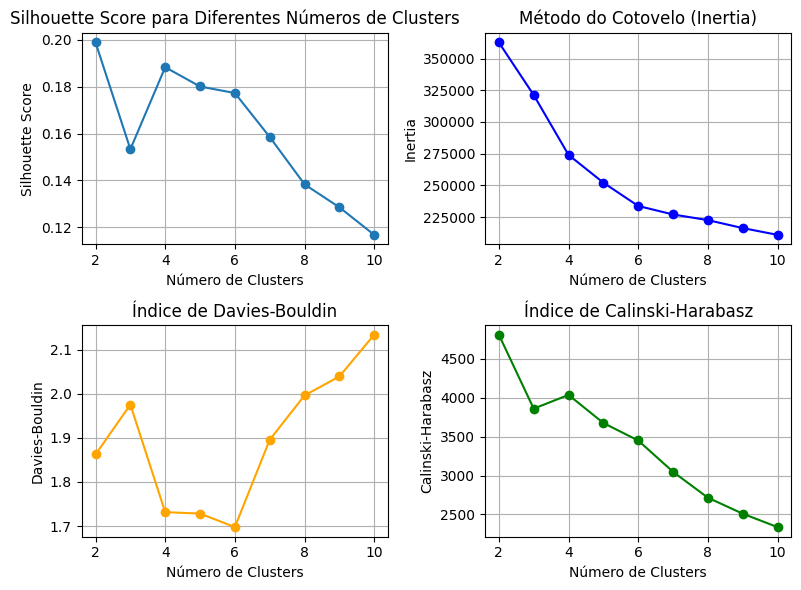

Utilizando o dataset tratado com MinMaxScale


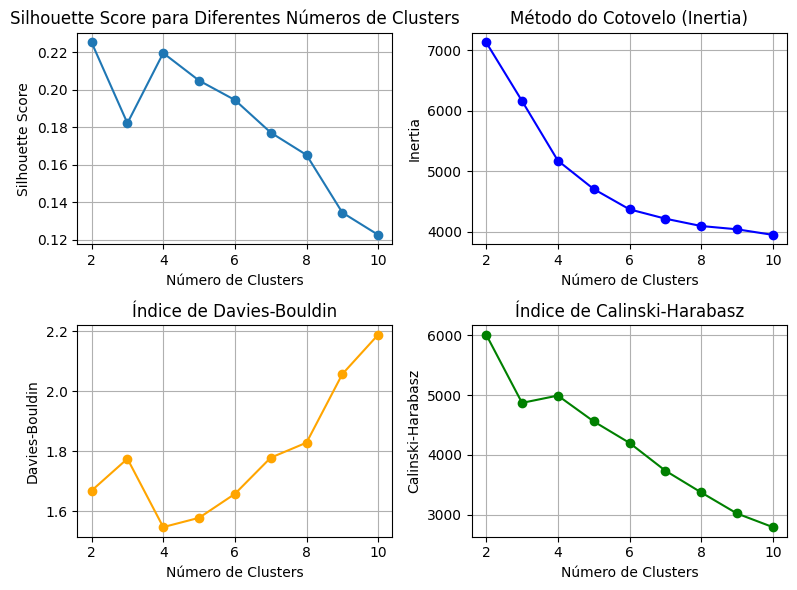

In [104]:
def clustering_evaluation(dataset, min_clusters=2, max_clusters=10):
    
    # Criando uma função que simultaneamente me indique o índice de silhoueta, um gráfico de cotovelo, 
    # além dos índices Davies-Bouldin e Calinski-Harabasz, para determinada faixa de número de clusters
    silhouette_scores = []
    inercias = []
    db_scores = []
    ch_scores = []
    
    # Iterando pelos números de clusters
    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=23)
        labels = kmeans.fit_predict(dataset)
        
        # Calculando os índices e adicionando nas listas criadas
        silhouette_scores.append(sklearn.metrics.silhouette_score(dataset, labels))
        inercias.append(kmeans.inertia_)
        db_scores.append(sklearn.metrics.davies_bouldin_score(dataset, labels))
        ch_scores.append(sklearn.metrics.calinski_harabasz_score(dataset, labels))
    
    plt.figure(figsize=(8, 6))
    
    # Gráfico 1: Silhouette Score
    plt.subplot(2, 2, 1)
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette Score')
    plt.title('Silhouette Score para Diferentes Números de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    # Gráfico 2: Método do Cotovelo
    plt.subplot(2, 2, 2)
    plt.plot(range(min_clusters, max_clusters + 1), inercias, marker='o', color='blue', label='Inertia')
    plt.title('Método do Cotovelo (Inertia)')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    
    # Gráfico 3: Davies-Bouldin 
    plt.subplot(2, 2, 3)
    plt.plot(range(min_clusters, max_clusters + 1), db_scores, marker='o', color='orange', label='Davies-Bouldin Index')
    plt.title('Índice de Davies-Bouldin')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Davies-Bouldin')
    plt.grid(True)
    
    # Gráfico 4: Calinski-Harabasz 
    plt.subplot(2, 2, 4)
    plt.plot(range(min_clusters, max_clusters + 1), ch_scores, marker='o', color='green', label='Calinski-Harabasz Index')
    plt.title('Índice de Calinski-Harabasz')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Calinski-Harabasz')
    plt.grid(True)
    
    # Ajustando o layout
    plt.tight_layout()
    plt.show()

#chamando essa função para os dois tratamentos de dados feitos

print("Utilizando o dataset tratado com StandartScale")
clustering_evaluation(dataset_tratado_ss, min_clusters=2, max_clusters=10)
 
print("Utilizando o dataset tratado com MinMaxScale")
clustering_evaluation(dataset_tratado_mm, min_clusters=2, max_clusters=10)


Tendo conhecimento sobre a minha base de dado, gostaria de dividir em clusters que me desse o máximo de informação possível. Buscar apenas uma otimização dos índices me levaria para a escolha de apenas 3 clustersm mas isso não me daria nem de perto a quantidade de informação necessária para que este projeto fosse relevante. Não havendo, neste estudo (apesar de disponível no dataset), diferenciação entre pé esquerdo e direito, considero o mínimo de clusters relevantes igual a quatro (goleiros, defensores, meio campo, atacante), ainda sendo pouca diferenciação para um resultado interessante. Portanto, gostaria de conseguir diferenciar mais ainda meus dados, separando defensores em zagueiros e laterais, e o meio campo entre meias ofensivos e volantes. Tendo isso em vista e considerando que há uma piora significativa na separação de 7 clusters em frente, vou definir o meu número de clusters como sendo 6, onde há um ponto de inflexão significativo nos índices de Davies-Boouldin e de Silhoueta. 

Dentre as formas de tratar os dados, noto primeiramente que meu atributo por sí só já era normalizado entre 0 e 100 antes da transformação que realizei. Notando que o silhouete score e o índice de Calinski-Harabasz são maiores, além do índice de Davies-Bouldin ser menor, decidi por utilizar o MinMaxScaler. Apesar de não termos, dentro dos dados, um evento com o limite superior e/ou inferior, eles existem nos atributos (que originalmente variam de 0 à 100), dessa forma não é possível que haja outliers muito exagerados (ou seja, em outras ordens de grandeza).

Silhouette Score: 0.195
Davies-Bouldin Index: 1.658
Calinski-Harabasz Index: 4201.972


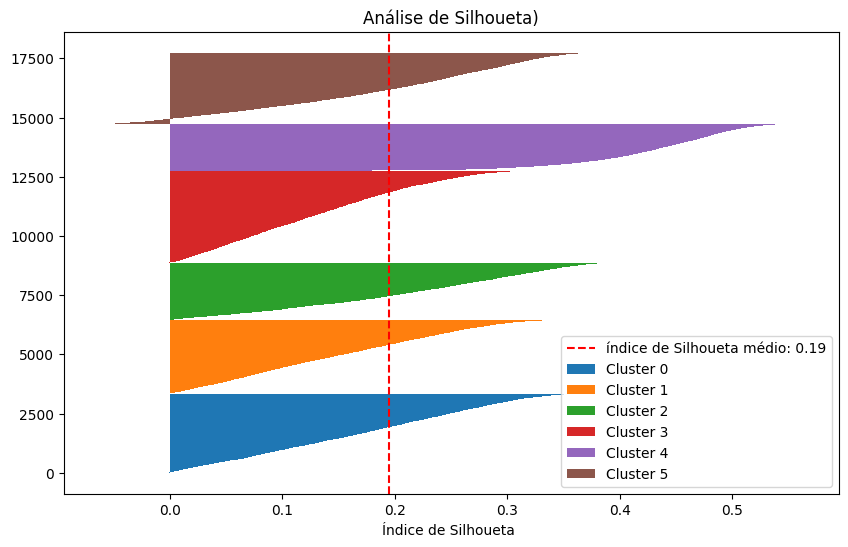

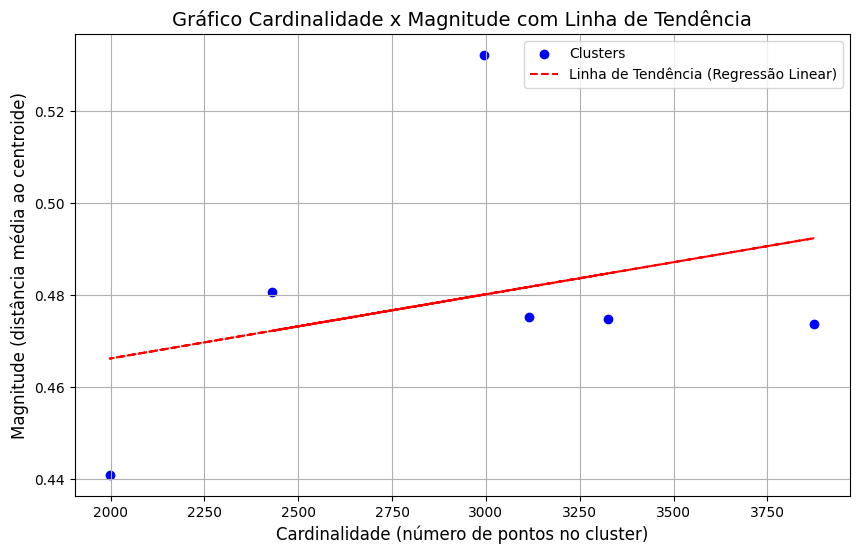

In [105]:

dataset_escolhido=dataset_tratado_mm.copy()

# Aplicando KMeans
n_clusters=6
kmeans = sklearn.cluster.KMeans(n_clusters, random_state=23, init= 'k-means++') 
kmeans_labels = kmeans.fit_predict(dataset_escolhido)

# Calculando a Silhouette Score para KMeans
indice_silhoueta_kmeans = sklearn.metrics.silhouette_score(dataset_escolhido, kmeans_labels)
indice_davies_bouldin_kmeans = sklearn.metrics.davies_bouldin_score(dataset_escolhido, kmeans_labels)
indice_calinski_harabasz_kmeans = sklearn.metrics.calinski_harabasz_score(dataset_escolhido, kmeans_labels)
print(f"Silhouette Score: {indice_silhoueta_kmeans:.3f}")
print(f"Davies-Bouldin Index: {indice_davies_bouldin_kmeans:.3f}")
print(f"Calinski-Harabasz Index: {indice_calinski_harabasz_kmeans:.3f}")


# Calculando os valores de Silhouette para cada amostra
silhoueta_valores = sklearn.metrics.silhouette_samples(dataset_escolhido, kmeans_labels)

# Visualizando o gráfico de Silhouette
fig, ax = plt.subplots(figsize=(10, 6))

# Criando um gráfico de barras para as pontuações de Silhouette
y_lower, y_upper = 0, 0
for i in range(n_clusters):  # número de clusters
    # Obter as pontuações de Silhouette para cada cluster
    cluster_silhoueta_valores = silhoueta_valores[kmeans_labels == i]
    cluster_silhoueta_valores.sort()

    y_upper += len(cluster_silhoueta_valores)
    ax.barh(range(y_lower, y_upper), cluster_silhoueta_valores, height=1.0, label=f'Cluster {i}')
    y_lower += len(cluster_silhoueta_valores)

# Plotando a linha da Silhouette Score média
ax.axvline(x=indice_silhoueta_kmeans, color='red', linestyle='--', label=f'índice de Silhoueta médio: {indice_silhoueta_kmeans:.2f}')

# Configurações do gráfico
ax.set_title('Análise de Silhoueta)')
ax.set_xlabel('Índice de Silhoueta ')
ax.legend()
plt.show()

unique_labels = np.unique(kmeans_labels)


# Dados: Cardinalidade e Magnitude
cardinalidade = [len(dataset_escolhido[np.array(kmeans_labels) == label]) for label in unique_labels]

# Calculando as magnitudes
magnitudes = []
for label in unique_labels:
    cluster_points = dataset_escolhido[np.array(kmeans_labels) == label]
    centroid = kmeans.cluster_centers_[label]
    # Calculando a distancia média dos pontos para o centroide
    magnitude = np.mean(np.linalg.norm(cluster_points - centroid, axis=1))
    magnitudes.append(magnitude)

# Convertendo para arrays NumPy para ajuste de modelo
cardinalidade = np.array(cardinalidade).reshape(-1, 1)
magnitudes = np.array(magnitudes)

# Fazendo a regressão linear
model = sklearn.linear_model.LinearRegression()
model.fit(cardinalidade, magnitudes)
trend_line = model.predict(cardinalidade)

# Plotando o gráfico com linha de tendência
plt.figure(figsize=(10, 6))
plt.scatter(cardinalidade, magnitudes, color='blue', label='Clusters')
plt.plot(cardinalidade, trend_line, color='red', linestyle='--', label='Linha de Tendência (Regressão Linear)')

# Títulos e rótulos
plt.title('Gráfico Cardinalidade x Magnitude com Linha de Tendência', fontsize=14)
plt.xlabel('Cardinalidade (número de pontos no cluster)', fontsize=12)
plt.ylabel('Magnitude (distância média ao centroide)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()



Agora em posse do gráfico de silhoueta, observo que ele é uma medida da qualidade da clusterização realizada, indicando o quão bem cada ponto está colocado em seu Cluster. Variando de -1 a 1, valores próximos de 1 indicam que o ponto está muito bem agrupado em seu cluster, estando muito mais próximo ao seu centróide do que aos demais. Valores próximos de 0 indicam que essa diferença não é tão grande, e ele poderia pertencer a outros clusters sem um impacto significativo na qualidade da clusterização, enquanto valores negativos indicam que este dado deve ter sido alocado no cluster errado.

Para chegar nesse valor, é dado com base em um valor de Coesão e um de Separação. Para a Coesão, é medida a distancia média entre um ponto e todos outros de seu cluster, e para a Separação, é medida a distancia média entre um ponto e todos os pontos de um outro cluster considerado mais próximo. O índice de silhoute é a média desse valor para todos os pontos do dataset.

Apesar de um índice de silhoueta não ideal (0,21), vemos que não há uma grande quantidade de dados alocada no cluster errado (valores negativos no gráfico). Tendo em mente a natureza dos nossos dados, os valores mais baixos de silhoueta podem representar jogadores que comumente atuam em diferentes funções, ou funções cuja diferenciação entre elas não é tão clara, como por exemplo um lateral que tenha atributos mais ofensivos, e um meio campo que atue mais aberto.

Para entender melhor estes clusters, vou buscar os atriibutos médios, bem os que são de maior destaque positivo e negativo em cada cluster.

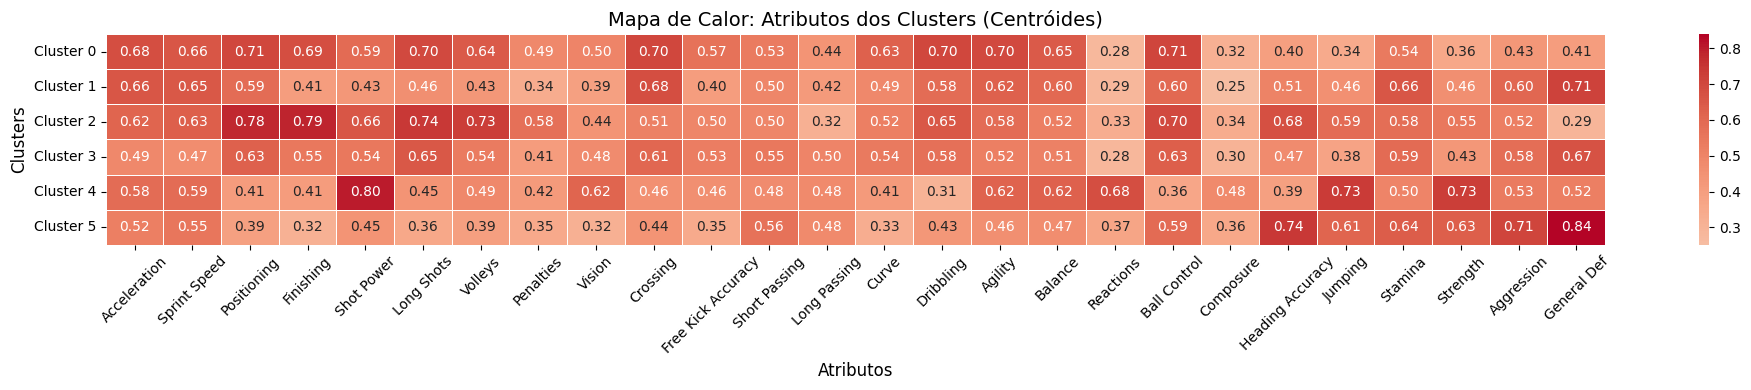

Tabela dos centróides dos clusters:


Acceleration  Sprint Speed  Positioning  Finishing  Shot Power  \
Cluster 0      0.682738      0.659263     0.705066   0.686123    0.589360   
Cluster 1      0.655269      0.648777     0.588045   0.407208    0.428296   
Cluster 2      0.616188      0.628632     0.784145   0.788411    0.657910   
Cluster 3      0.486258      0.471681     0.627529   0.547250    0.544160   
Cluster 4      0.583704      0.587691     0.408064   0.410880    0.801551   
Cluster 5      0.518691      0.550249     0.389812   0.315038    0.446626   

           Long Shots   Volleys  Penalties    Vision  Crossing  ...   Balance  \
Cluster 0    0.696144  0.644676   0.488470  0.499357  0.703247  ...  0.645509   
Cluster 1    0.458521  0.429568   0.338584  0.389497  0.684507  ...  0.598559   
Cluster 2    0.744949  0.730947   0.576518  0.442748  0.514801  ...  0.520055   
Cluster 3    0.649625  0.535303   0.408345  0.476070  0.605423  ...  0.513070   
Cluster 4    0.446646  0.488737   0.415454  0.615269  0.456292  ...  0.623945   
Cluster 5    0.360540  0.394463   0.351988  0.318715  0.442435  ...  0.466725   

           Reactions  Ball Control  Composure  Heading Accuracy   Jumping  \
Cluster 0   0.280635      0.712102   0.321865          0.397947  0.344916   
Cluster 1   0.287173      0.598201   0.251848          0.510461  0.455260   
Cluster 2   0.330575      0.700085   0.341002          0.676651  0.586567   
Cluster 3   0.284711      0.628937   0.302407          0.474267  0.375853   
Cluster 4   0.684798      0.363627   0.481217          0.392480  0.733292   
Cluster 5   0.371570      0.590136   0.357832          0.744504  0.612460   

            Stamina  Strength  Aggression  General Def  
Cluster 0  0.542135  0.357415    0.432811     0.405248  
Cluster 1  0.657185  0.459642    0.603070     0.714704  
Cluster 2  0.581361  0.547978    0.518662     0.288609  
Cluster 3  0.589344  0.431234    0.579835     0.671949  
Cluster 4  0.500818  0.730186    0.534093     0.518980  
Cluster 5  0.637691  0.631164    0.710950     0.838570  

[6 rows x 26 columns]


Cluster 0:
  3 Atributos mais positivos: ['Ball Control', 'Positioning', 'Crossing']
  3 Atributos mais negativos: ['Reactions', 'Composure', 'Jumping']

Cluster 1:
  3 Atributos mais positivos: ['General Def', 'Crossing', 'Stamina']
  3 Atributos mais negativos: ['Composure', 'Reactions', 'Penalties']

Cluster 2:
  3 Atributos mais positivos: ['Finishing', 'Positioning', 'Long Shots']
  3 Atributos mais negativos: ['General Def', 'Long Passing', 'Reactions']

Cluster 3:
  3 Atributos mais positivos: ['General Def', 'Long Shots', 'Ball Control']
  3 Atributos mais negativos: ['Reactions', 'Composure', 'Jumping']

Cluster 4:
  3 Atributos mais positivos: ['Shot Power', 'Jumping', 'Strength']
  3 Atributos mais negativos: ['Dribbling', 'Ball Control', 'Heading Accuracy']

Cluster 5:
  3 Atributos mais positivos: ['General Def', 'Heading Accuracy', 'Aggression']
  3 Atributos mais negativos: ['Finishing', 'Vision', 'Curve']


In [106]:
# Obtendo os centróides
centroids = kmeans.cluster_centers_

# Convertendo os centróides para um DataFrame para facilitar a manipulação e visualização
centroids_df = pd.DataFrame(centroids, columns=dataset_escolhido.columns)

# Nomeando os clusters no DataFrame
centroids_df.index = [f"Cluster {i}" for i in range(len(centroids))]

# Criando um mapa de calor para os atributos mais relevantes
plt.figure(figsize=(20, 4))
sns.heatmap(centroids_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)

# Adicionando título e rótulos
plt.title('Mapa de Calor: Atributos dos Clusters (Centróides)', fontsize=14)
plt.xlabel('Atributos', fontsize=12)
plt.ylabel('Clusters', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Exibindo a tabela de centróides (valores numéricos)
print("Tabela dos centróides dos clusters:")
display(centroids_df)

# Identificando os 3 atributos mais influentes (positivos e negativos) para cada cluster
for i, row in centroids_df.iterrows():
    top_3_positive = row.sort_values(ascending=False).head(3)
    top_3_negative = row.sort_values().head(3)
    
    print(f"\n{i}:")
    print(f"  3 Atributos mais positivos: {list(top_3_positive.index)}")
    print(f"  3 Atributos mais negativos: {list(top_3_negative.index)}")


Para melhor visualização, vou fazer um gráfico de radar 

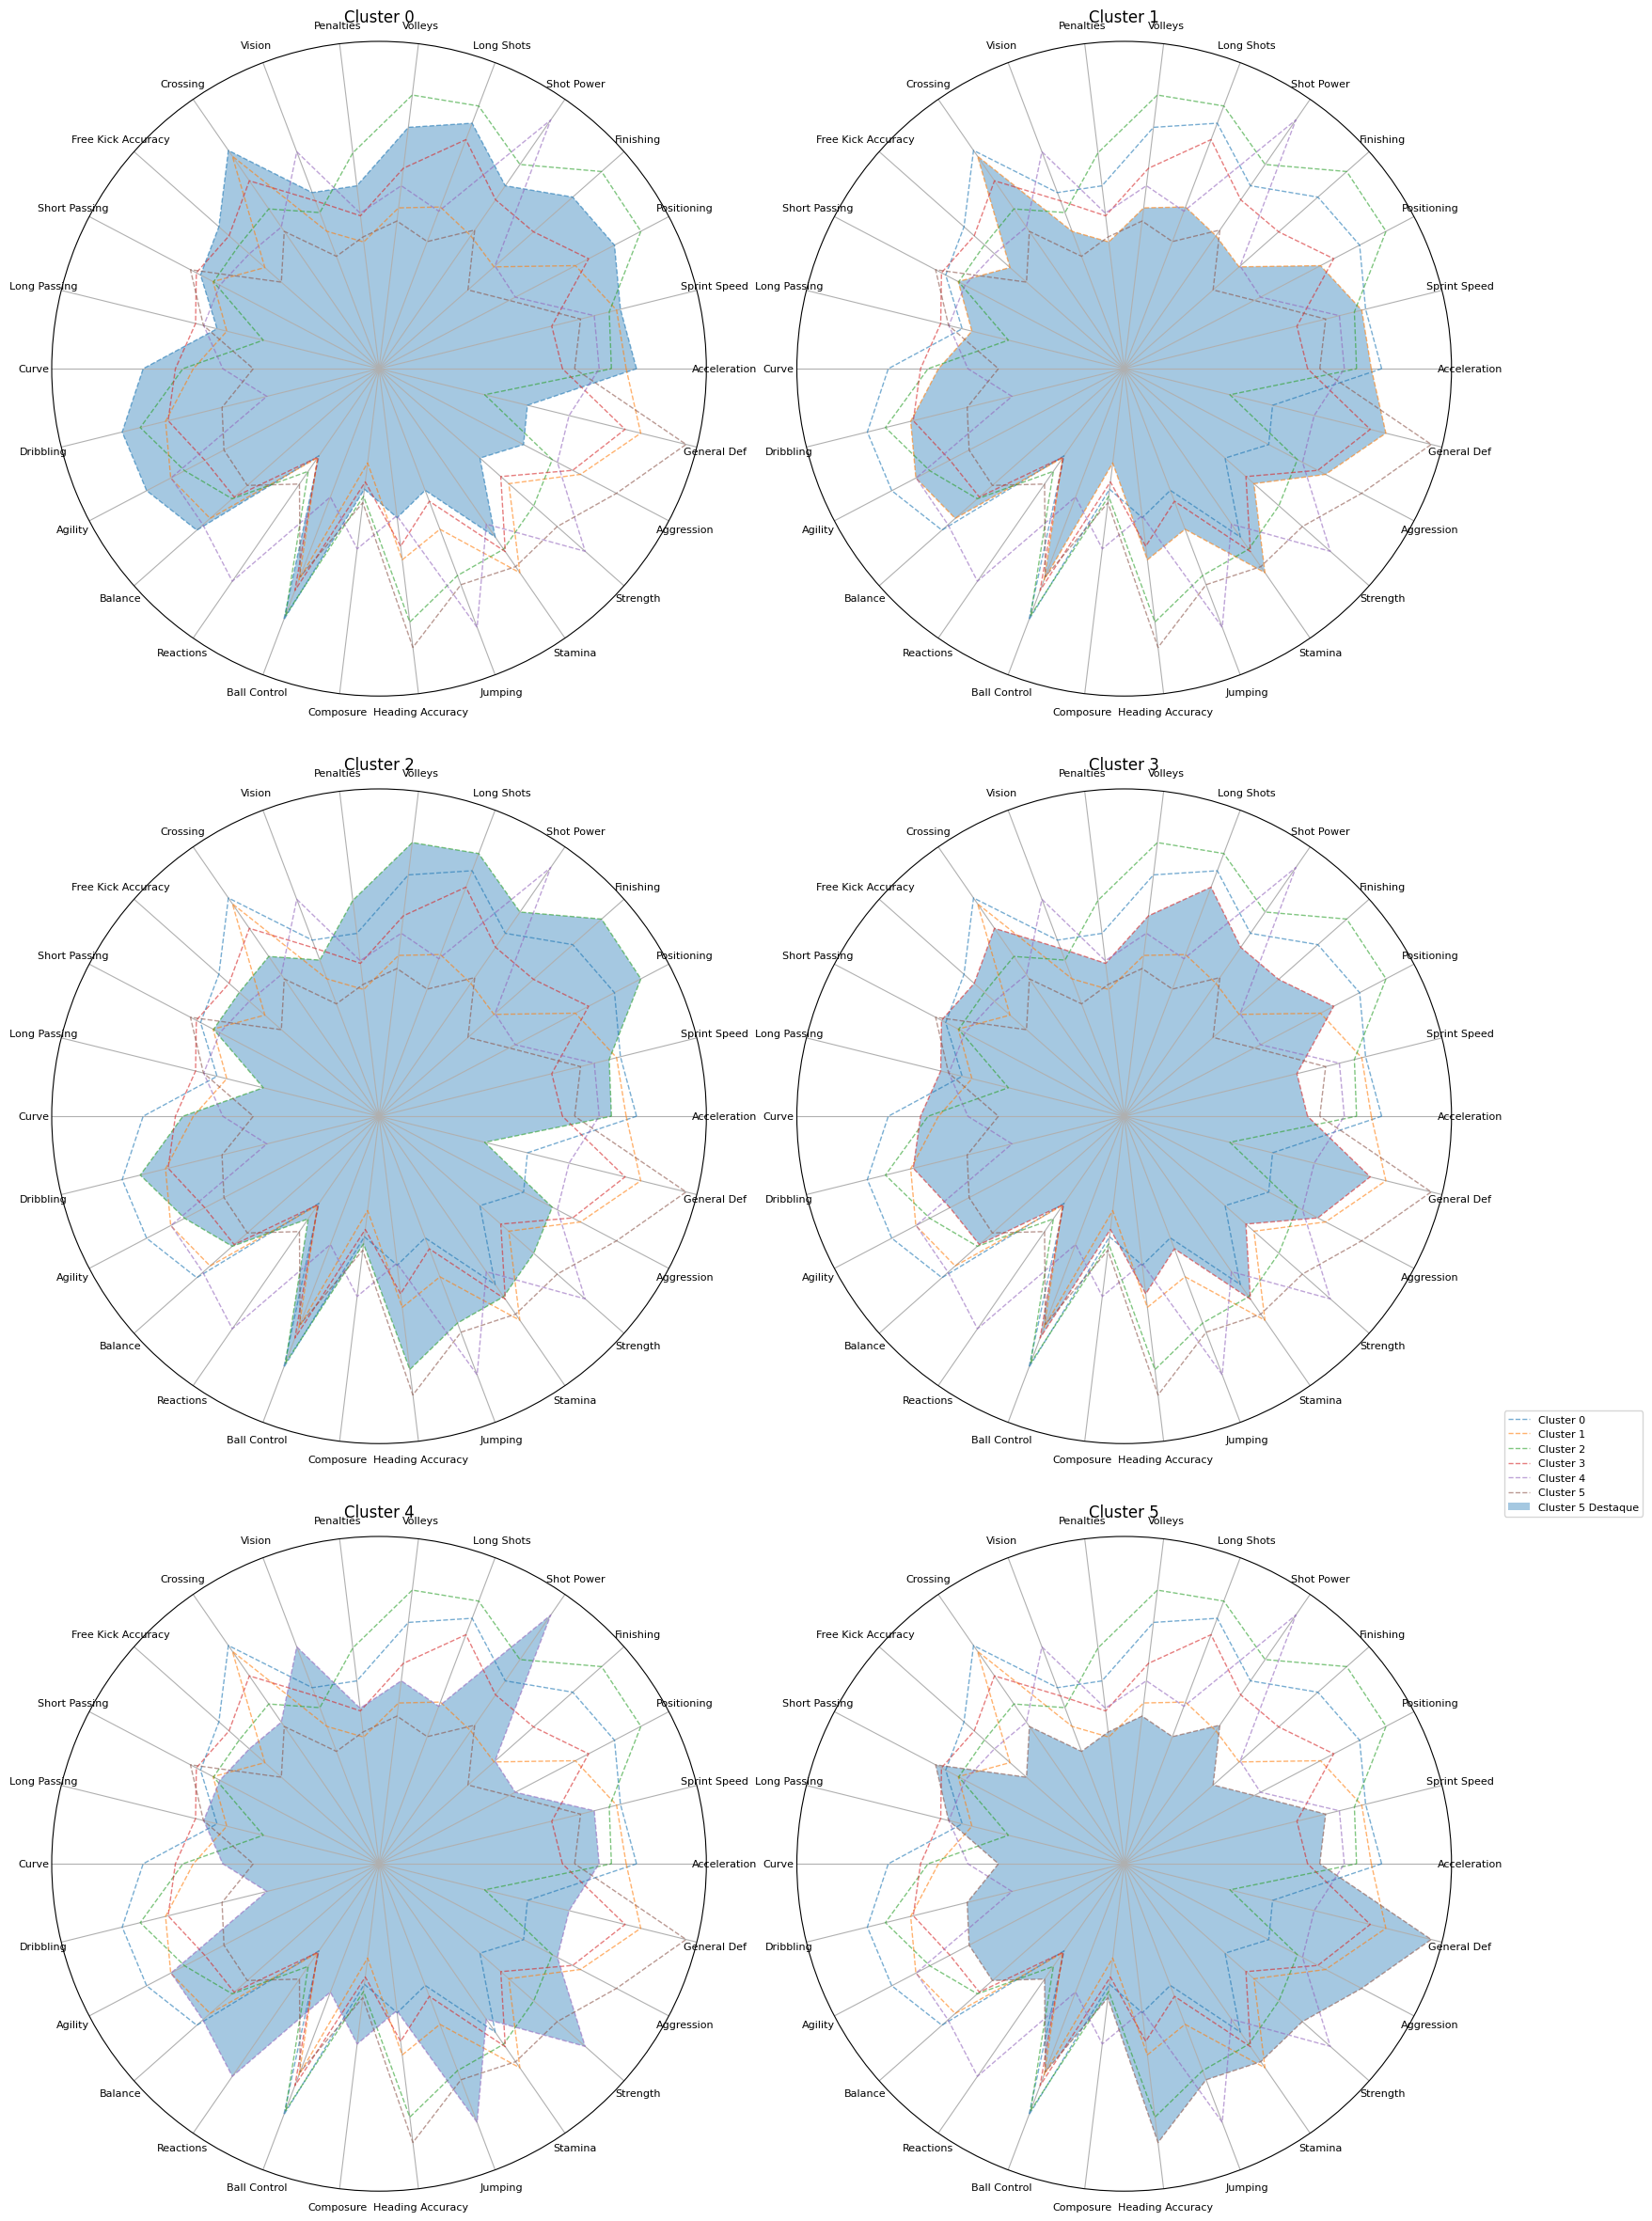

In [107]:
# Obtendo os nomes dos atributos
atributos = centroids_df.columns.tolist()

# Criando ângulos para o gráfico radar (1 para cada atributo)
num_atributos = len(atributos)
angles = [n / float(num_atributos) * 2 * math.pi for n in range(num_atributos)]
angles += angles[:1]  # Fechando o círculo

# Configurando o layout para 2x2 + 1
fig, axes = plt.subplots(3, 2, figsize=(16, 24), subplot_kw=dict(polar=True))

# Transformando os eixos 3x2 em uma lista plana para iterar
axes = axes.flatten()

# Criando um gráfico para cada cluster 
for idx in range(len(centroids_df)):
    ax = axes[idx]
    cluster_name = f"Cluster {idx}"
    
    # Plotando todos os clusters com linhas
    for i, row in centroids_df.iterrows():
        valores = row.tolist()
        valores += valores[:1]  # Fechando o círculo
        ax.plot(angles, valores, label=i, linestyle='--', alpha=0.6, linewidth=1)

    # Destacando o cluster atual com preenchimento
    valores_destacados = centroids_df.loc[cluster_name].tolist()
    valores_destacados += valores_destacados[:1]
    ax.fill(angles, valores_destacados, alpha=0.4, label=f"Cluster {idx} Destaque")
    
    # Configurações do gráfico
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(atributos, fontsize=8)
    ax.set_yticks([])
    ax.set_title(cluster_name, fontsize=12, pad=15)

# Ajustando layout geral
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.2), fontsize=8)
plt.show()


Com base nos principais atributos de cada Cluster, bem como nos gráficos criados, podemos classificar os clusters da seguinte forma:

- Cluster 0: Meias
  - Pontos positivos de controle de bola, posicionamento e cruzamento, além de bons números de visão de jogo, chutes e dribles. A segunda pior capacidade de defesa da análise

- Cluster 1: Laterais
  - Bons fundamentos defensivos aliados a um bom cruzamento e estamina para correr na lateral, além de boa velocidade, aceleração e agilidade

- Cluster 2: Atacantes
  - Melhores atributos de finalização, ótimo posicionamento, bons pulos, cabeceadas, batidas de pênaltis, drible e controle de bola. E péssima capacidade defensiva.

- Cluster 3: Volantes
  - Boa capacidade defensiva aliada a chutes fortes, controle de bola e bom passe.

- Cluster 4: Goleiros
  - Ótima força de chute mas baixa finalização, ótimo pulo mas ruim cabeceio, força e reação altas, o pior em drible e controle de bola.

- Cluster 5: Zagueiros
  - Os melhores atributos defensivos, além de um ótimo cabeceio e agressividade. Atributos ofensivos ruins.


Vale neste momento retornar ao gráfico de silhoueta e reparar como o cluster de goleiros é muito bem definido, enquanto outros como o de zagueiros e volantes possuem muitos elementos com índice de silhoueta baixo ou até mesmo alguns negativos. Sendo funções com um maior overlap de atributos, além de comumente ter jogadores que migram eventualmente para outras posições, é esperado que estes clusters sejam menos definidos.

Muitos testes foram realizados com o DBScan, e não foi possível chegar em clusters utilizando o dataset do kmeans. Portanto, buscando diminuir drasticamente a dimensionalidade, apliquei um PCA diminuindo para apenas 6 variáveis.

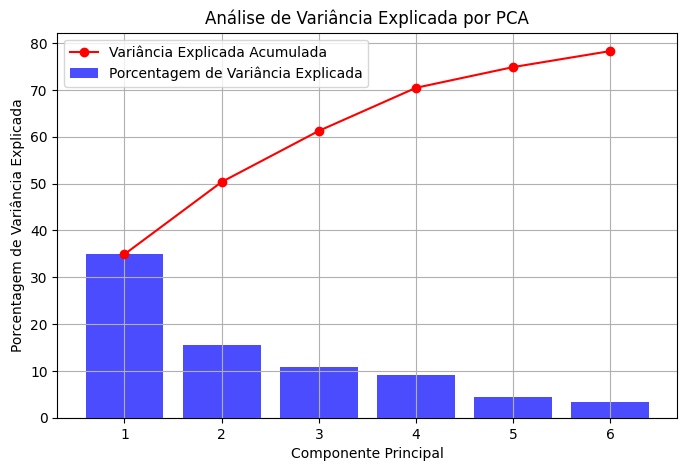

Componente Principal 1: 0.349 (34.90%)
Componente Principal 2: 0.154 (15.43%)
Componente Principal 3: 0.109 (10.91%)
Componente Principal 4: 0.092 (9.20%)
Componente Principal 5: 0.044 (4.42%)
Componente Principal 6: 0.034 (3.42%)

Dados transformados (projeção para PCs):
        PC1       PC2       PC3       PC4       PC5       PC6
0  0.772813  0.264695 -0.056204  0.173551  0.188132  0.132238
1 -0.034910 -0.121806 -0.547695 -0.398535  0.046772  0.031584
2  0.475355  0.534787 -0.422204  0.253671  0.003558 -0.015181
3  0.196150 -0.044550 -0.320254 -0.119668  0.121176 -0.257368
4  0.935001  0.082163  0.143902 -0.019289  0.293632  0.119023


In [108]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dataset_escolhido=dataset_tratado_mm

# Aplicando PCA
n_componentes = 6  
pca = PCA(n_components=n_componentes)
pca.fit(dataset_escolhido)

# Transformação dos dados
dataset_pca = pca.transform(dataset_escolhido)

# Variância explicada por cada componente principal
variancia_explicada = pca.explained_variance_ratio_

# Plot da variância explicada
plt.figure(figsize=(8, 5))
plt.bar(range(1, n_componentes + 1), variancia_explicada * 100, alpha=0.7, color='blue', label='Porcentagem de Variância Explicada')
plt.plot(range(1, n_componentes + 1), np.cumsum(variancia_explicada) * 100, marker='o', color='red', label='Variância Explicada Acumulada')
plt.title('Análise de Variância Explicada por PCA')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentagem de Variância Explicada')
plt.legend(loc='best')
plt.grid()
plt.show()

# Exibindo as variâncias explicadas
for i, var in enumerate(variancia_explicada, start=1):
    print(f"Componente Principal {i}: {var:.3f} ({var*100:.2f}%)")

# Dados transformados (projeção para os PCs)
dados_transformados_df = pd.DataFrame(dataset_pca, columns=[f"PC{i+1}" for i in range(n_componentes)])
print("\nDados transformados (projeção para PCs):")
print(dados_transformados_df.head())

Começando agora o DBSCAN, vou primeiro checar a distância para os vizinhos mais próximos, para ter uma ideia da escala de eps que vamos lidar. 

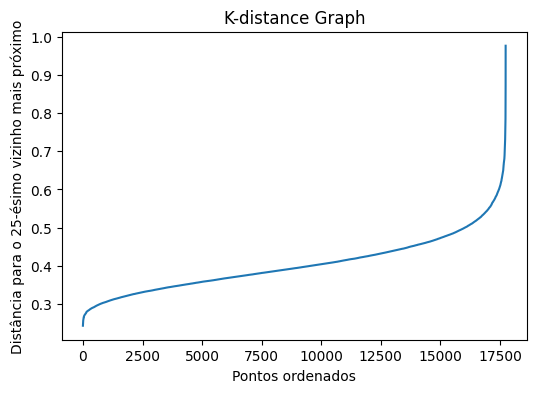

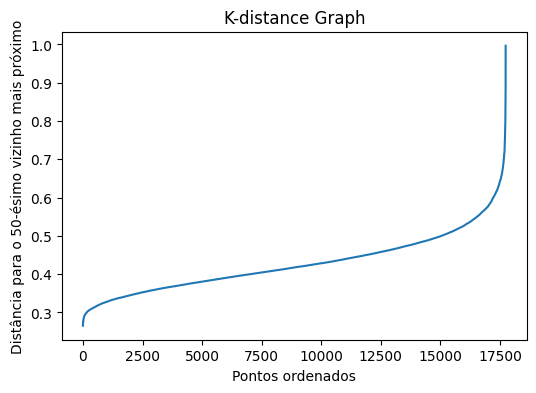

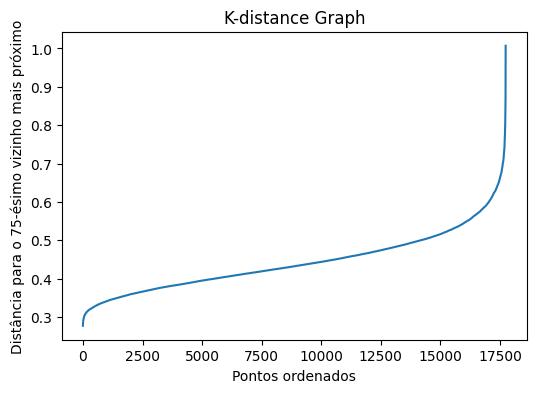

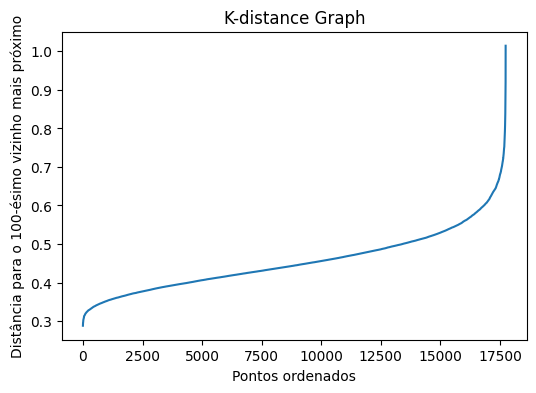

In [109]:
for k in np.arange(25, 101, 25):
    neighbors = sklearn.neighbors.NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(dataset_escolhido)
    distances, indices = neighbors_fit.kneighbors(dataset_escolhido)

    # Ordenar as distâncias para o gráfico
    distances = np.sort(distances[:, k-1], axis=0)

    # Plotando o gráfico de distâncias
    plt.figure(figsize=(6, 4))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Pontos ordenados')
    plt.ylabel(f'Distância para o {k}-ésimo vizinho mais próximo')
    plt.show()



Foi inicialmente considerado valores de 0.6 para cima, contudo infelizmente não consegui formar mais do que um cluster com essa configuração. Após muitos testes, obtive clusters apenas nos valores de eps próximos a 0.2. nesta faixa, vou testar diferentes eps e números mínimos de amostra para um cluster, buscando o melhor par possível. 

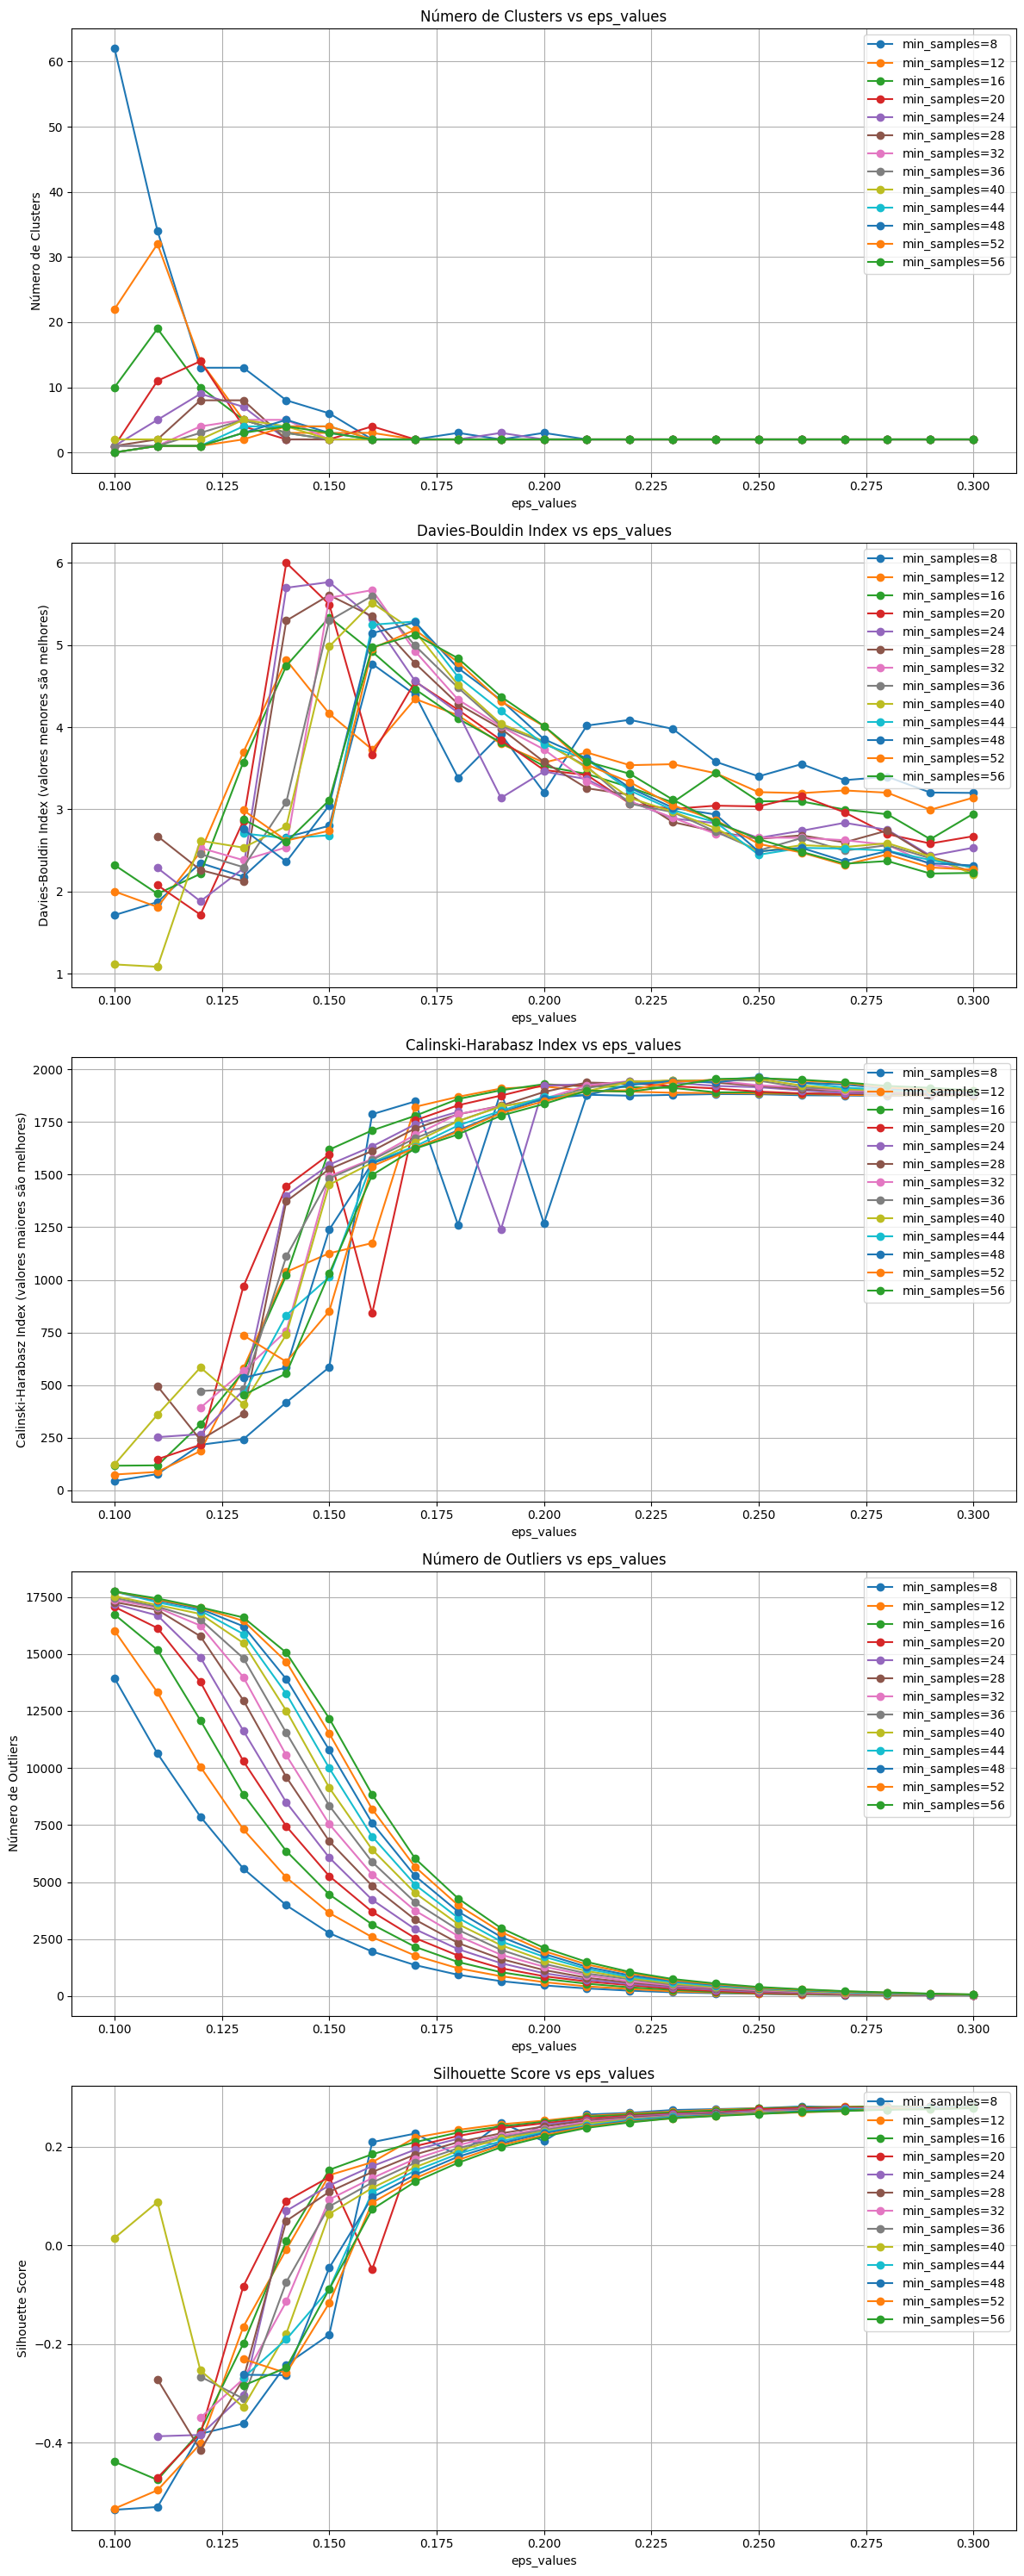

In [110]:
# Definir o dataset escolhido
dataset_escolhido = dataset_pca

# Valor fixo de min_samples (intervalo)
min_samples_values = np.arange(8, 57, 4)  # Intervalo de valores
eps_values = np.arange(0.1, 0.31, 0.01)  # Faixa de valores para eps

# Configurando a figura com 5 subplots
plt.figure(figsize=(12, 30))

# Gráfico 1: Número de Clusters
plt.subplot(5, 1, 1)
plt.title("Número de Clusters vs eps_values")
plt.xlabel("eps_values")
plt.ylabel("Número de Clusters")
plt.grid()

# Gráfico 2: Davies-Bouldin Index
plt.subplot(5, 1, 2)
plt.title("Davies-Bouldin Index vs eps_values")
plt.xlabel("eps_values")
plt.ylabel("Davies-Bouldin Index (valores menores são melhores)")
plt.grid()

# Gráfico 3: Calinski-Harabasz Index
plt.subplot(5, 1, 3)
plt.title("Calinski-Harabasz Index vs eps_values")
plt.xlabel("eps_values")
plt.ylabel("Calinski-Harabasz Index (valores maiores são melhores)")
plt.grid()

# Gráfico 4: Número de Outliers
plt.subplot(5, 1, 4)
plt.title("Número de Outliers vs eps_values")
plt.xlabel("eps_values")
plt.ylabel("Número de Outliers")
plt.grid()

# Gráfico 5: Silhouette Score
plt.subplot(5, 1, 5)
plt.title("Silhouette Score vs eps_values")
plt.xlabel("eps_values")
plt.ylabel("Silhouette Score")
plt.grid()

# Loop principal
for min_samples in min_samples_values:
    num_clusters = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    num_outliers = []
    silhouette_scores = []

    for eps in eps_values:
        # Treinando o DBSCAN
        dbscan = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(dataset_escolhido)

        # Número de clusters (excluindo rótulo -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        num_clusters.append(n_clusters)

        # Número de outliers (rótulo -1)
        outliers = list(labels).count(-1)
        num_outliers.append(outliers)

        # Calculando Davies-Bouldin e Calinski-Harabasz Index apenas para n_clusters > 1
        if n_clusters > 1:
            db_score = sklearn.metrics.davies_bouldin_score(dataset_escolhido, labels)
            ch_score = sklearn.metrics.calinski_harabasz_score(dataset_escolhido, labels)
            davies_bouldin_scores.append(db_score)
            calinski_harabasz_scores.append(ch_score)

            # Calculando o Silhouette Score
            silhouette_avg = sklearn.metrics.silhouette_score(dataset_escolhido, labels)
            silhouette_scores.append(silhouette_avg)
        else:
            davies_bouldin_scores.append(None)  # Não é calculável
            calinski_harabasz_scores.append(None)  # Não é calculável
            silhouette_scores.append(None)

    # Plotando para cada min_samples
    plt.subplot(5, 1, 1)
    plt.plot(eps_values, num_clusters, marker='o', label=f"min_samples={min_samples}")

    plt.subplot(5, 1, 2)
    plt.plot(eps_values, davies_bouldin_scores, marker='o', label=f"min_samples={min_samples}")

    plt.subplot(5, 1, 3)
    plt.plot(eps_values, calinski_harabasz_scores, marker='o', label=f"min_samples={min_samples}")

    plt.subplot(5, 1, 4)
    plt.plot(eps_values, num_outliers, marker='o', label=f"min_samples={min_samples}")

    plt.subplot(5, 1, 5)
    plt.plot(eps_values, silhouette_scores, marker='o', label=f"min_samples={min_samples}")

# Adicionando legendas
plt.subplot(5, 1, 1)
plt.legend(loc="upper right")

plt.subplot(5, 1, 2)
plt.legend(loc="upper right")

plt.subplot(5, 1, 3)
plt.legend(loc="upper right")

plt.subplot(5, 1, 4)
plt.legend(loc="upper right")

plt.subplot(5, 1, 5)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()



Apesar de serem resultados pouco animadores, vou analisar com o seguinte viés:

O método de silhoueta compara a distancia dos pontos para os centroides do seu cluster com outros clusters, ele não é muito indicado para clusters que tenham formatos irregulares, visto que essa distância medida funciona como um "raio de influência" do centroide de cada cluster. Portanto, não é um método tão indicado para DBSCAN. 

O método Calisnki-Harabasz visa medir a proporção da disperção na região entre clusters, e a disperção dos clusters em si. É também, portanto, mais indicado para clusters com formato regular, e presença baixa de outliers, o que ocorre com valores maiores de eps neste caso, podendo portando ser considerado também na análise, de forma secundária.

Por fim, o método de Davies-Bouldin mede a razão entre o quão compacto é um cluster e a separação entre os clusters. Visto que esta medida é análoga à densidade, é a metodologia que me parece mais adequada para lidar com DBSCAN. É também uma métrica sensível a outliers, portanto valores de eps e min_samples que diminuam os outliers são preferíveis.

Buscando um mínimo de 3 clusters, tentando evitar clusters extremamente pequenos, e admitindo a possibilidade de alguns outliers, considero a opção de min_samples = 24 e eps =0.19 a mais razoavel, noto que há um mínimo locar no gráfico de Davies-Bouldin.

Silhouette Score: 0.203
Davies-Bouldin Index: 3.139
Calinski-Harabasz Index: 1240.164
Número de clusters: 3
Número de outliers: 1443


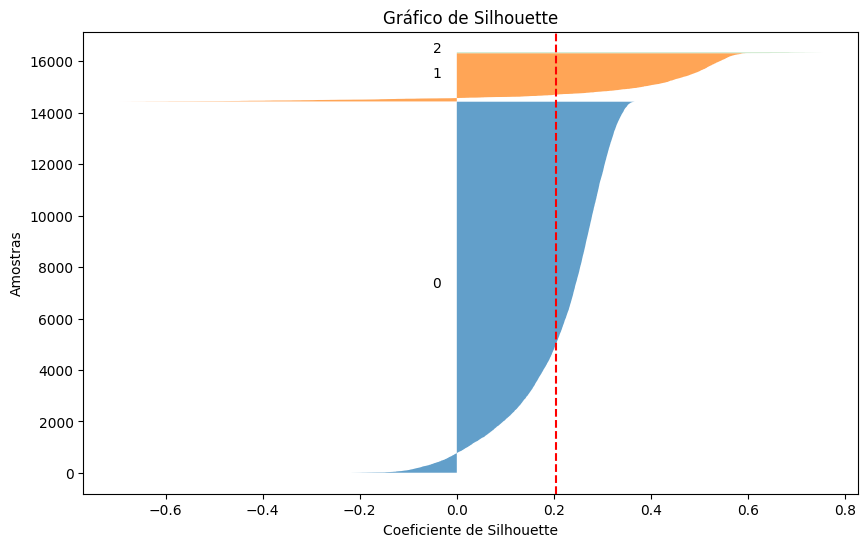

Cluster 0: Cardinalidade = 14411, Magnitude média = 0.557
Cluster 1: Cardinalidade = 1869, Magnitude média = 0.262
Cluster 2: Cardinalidade = 14, Magnitude média = 0.134


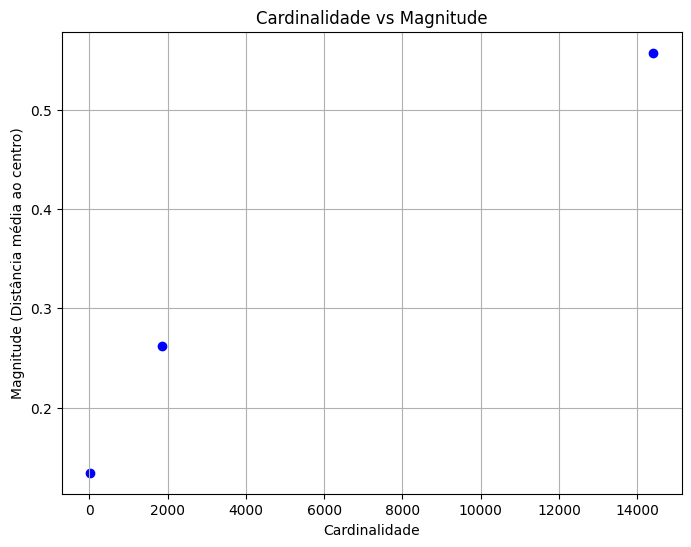

In [111]:
# Configurações do DBSCAN
min_samples = 24
eps = 0.19

# Treinando o DBSCAN
dbscan = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(dataset_escolhido)

# Número de clusters (excluindo rótulo -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_outliers = list(labels).count(-1)

# Cálculo dos índices
silhouette_avg = sklearn.metrics.silhouette_score(dataset_escolhido, labels, metric="euclidean")
davies_bouldin = sklearn.metrics.davies_bouldin_score(dataset_escolhido, labels)
calinski_harabasz = sklearn.metrics.calinski_harabasz_score(dataset_escolhido, labels)

# Exibição dos índices
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
print(f"Número de clusters: {n_clusters}")
print(f"Número de outliers: {num_outliers}")

# Plot do gráfico de silhouette
silhouette_values = sklearn.metrics.silhouette_samples(dataset_escolhido, labels, metric="euclidean")

# Organizar por clusters para facilitar visualização
y_lower = 10
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_silhouette_values = silhouette_values[labels == i]
    cluster_silhouette_values.sort()

    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))

    y_lower = y_upper + 10  # Espaço entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Gráfico de Silhouette")
plt.xlabel("Coeficiente de Silhouette")
plt.ylabel("Amostras")
plt.show()

# Cálculo da Cardinalidade e Magnitude para cada cluster
cardinality = []
magnitude = []

for cluster_id in set(labels):
    if cluster_id != -1:  # Ignorando outliers
        cluster_points = dataset_escolhido[labels == cluster_id]
        cardinality.append(len(cluster_points))

        # Cálculo da magnitude (distância média dos pontos ao centro do cluster)
        center = cluster_points.mean(axis=0)
        distances = np.linalg.norm(cluster_points - center, axis=1)
        magnitude.append(np.mean(distances))

# Exibindo Cardinalidade e Magnitude
for i, (card, mag) in enumerate(zip(cardinality, magnitude)):
    print(f"Cluster {i}: Cardinalidade = {card}, Magnitude média = {mag:.3f}")

# Plot Cardinalidade vs Magnitude
plt.figure(figsize=(8, 6))
plt.scatter(cardinality, magnitude, c='blue', marker='o')
plt.title("Cardinalidade vs Magnitude")
plt.xlabel("Cardinalidade")
plt.ylabel("Magnitude (Distância média ao centro)")
plt.grid(True)
plt.show()


Buscar uma média de atributos mais ou menos relevantes para os clusters vai considerar que estes clusters tem tamanho regular aproximadamente esférico, o que não é necessáriamente o caso com o DBSCAN. Portanto, para tentar visualizar/entender melhor essa clusterização vou realizar uma análise de PCA. Lembrando que os dados já estão normalizados com MinMaxScaler. É interessante analisar que o gráfico magnitude x cardinalidade é bem expresso por uma reta neste caso.

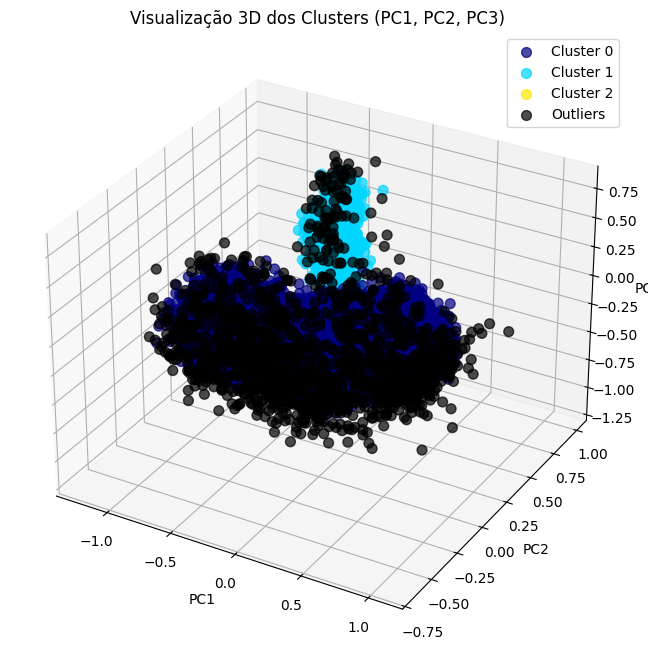

In [112]:
from mpl_toolkits.mplot3d import Axes3D

# Criando a visualização 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando cada cluster com uma cor diferente
unique_labels = set(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

for cluster_id, color in zip(unique_labels, colors):
    if cluster_id == -1:  # Outliers
        cluster_color = 'k'  # Preto para outliers
        cluster_label = 'Outliers'
    else:
        cluster_color = color
        cluster_label = f'Cluster {cluster_id}'
    
    cluster_points = dataset_escolhido[labels == cluster_id]
    ax.scatter(
        cluster_points[:, 0],  # Primeiro componente principal (PC1)
        cluster_points[:, 1],  # Segundo componente principal (PC2)
        cluster_points[:, 2],  # Terceiro componente principal (PC3)
        c=[cluster_color], label=cluster_label, s=50, alpha=0.7
    )

# Configurando o gráfico
ax.set_title("Visualização 3D dos Clusters (PC1, PC2, PC3)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()



Notamos pelo gráfico que os outliers em alta quantidade realmente poluem ainda muito a visualização, bem como a dificuldade de encontrar o cluster 2 devido ao seu tamanho. No mais, parece haver uma clara separação entre os clusters 0 e 1. Teorizo que este cluster 0 é referente à uma posição altamente diferenciada, Goleiros, e vou comparar agora com esses mesmos dados (com o PCA aplicado), mas com o label do Kmeans, e sem a poluição dos outliers.

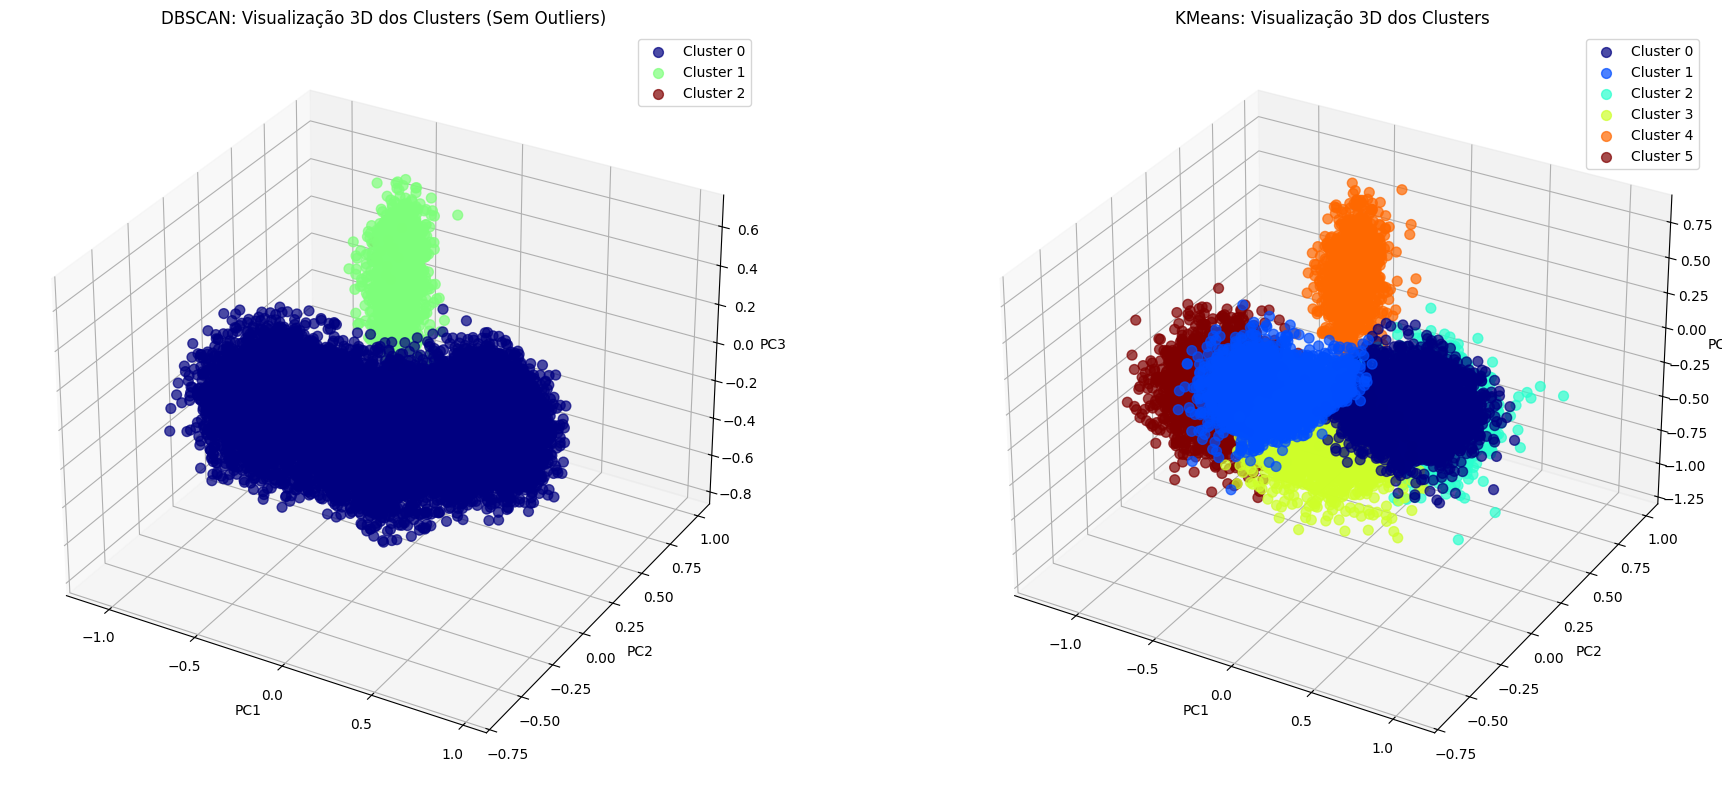

In [113]:
from mpl_toolkits.mplot3d import Axes3D

# Criando a figura para exibir dois gráficos lado a lado
fig = plt.figure(figsize=(20, 8))

# Gráfico 1: Visualização 3D dos Clusters DBSCAN (Sem Outliers)
ax1 = fig.add_subplot(121, projection='3d')

# Filtrar os dados para remover outliers (rótulo -1)
filtered_dataset = dataset_escolhido[labels != -1]
filtered_labels = labels[labels != -1]

# Plotando cada cluster com uma cor diferente (DBSCAN)
unique_labels = set(filtered_labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

for cluster_id, color in zip(unique_labels, colors):
    cluster_points = filtered_dataset[filtered_labels == cluster_id]
    ax1.scatter(
        cluster_points[:, 0],  # Primeiro componente principal (PC1)
        cluster_points[:, 1],  # Segundo componente principal (PC2)
        cluster_points[:, 2],  # Terceiro componente principal (PC3)
        c=[color], label=f'Cluster {cluster_id}', s=50, alpha=0.7
    )

# Configurando o gráfico 1
ax1.set_title("DBSCAN: Visualização 3D dos Clusters (Sem Outliers)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.legend()

# Gráfico 2: Visualização 3D dos Clusters KMeans
ax2 = fig.add_subplot(122, projection='3d')

# Plotando cada cluster com uma cor diferente (KMeans)
unique_kmeans_labels = set(kmeans_labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_kmeans_labels)))

for cluster_id, color in zip(unique_kmeans_labels, colors):
    cluster_points = dataset_pca[kmeans_labels == cluster_id]
    ax2.scatter(
        cluster_points[:, 0],  # Primeiro componente principal (PC1)
        cluster_points[:, 1],  # Segundo componente principal (PC2)
        cluster_points[:, 2],  # Terceiro componente principal (PC3)
        c=[color], label=f'Cluster {cluster_id}', s=50, alpha=0.7
    )

# Configurando o gráfico 2
ax2.set_title("KMeans: Visualização 3D dos Clusters")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.legend()

# Ajustando o layout
plt.tight_layout()
plt.show()


De fato, com essa visualização vemos que o cluster1 é quase totalmente referente ao cluster de goleiros no Kmeans, entquanto o 0 de divide entre as demais posições. Uma possível nova etapa para melhorar essa clusterização com o DBSCAN seria tentar separar o cluster 0 em mais alguns clusters, obtendo assim uma melhor divisão.

Voltando agora um pouco ao Kmeans, como a própria base de dados antes de ser manipulada possui informações sobre a posição de cada jogador, podemos ver as posições mais comuns dentro de cada cluster e analisar se a minha interpretação foi correta ou não. 

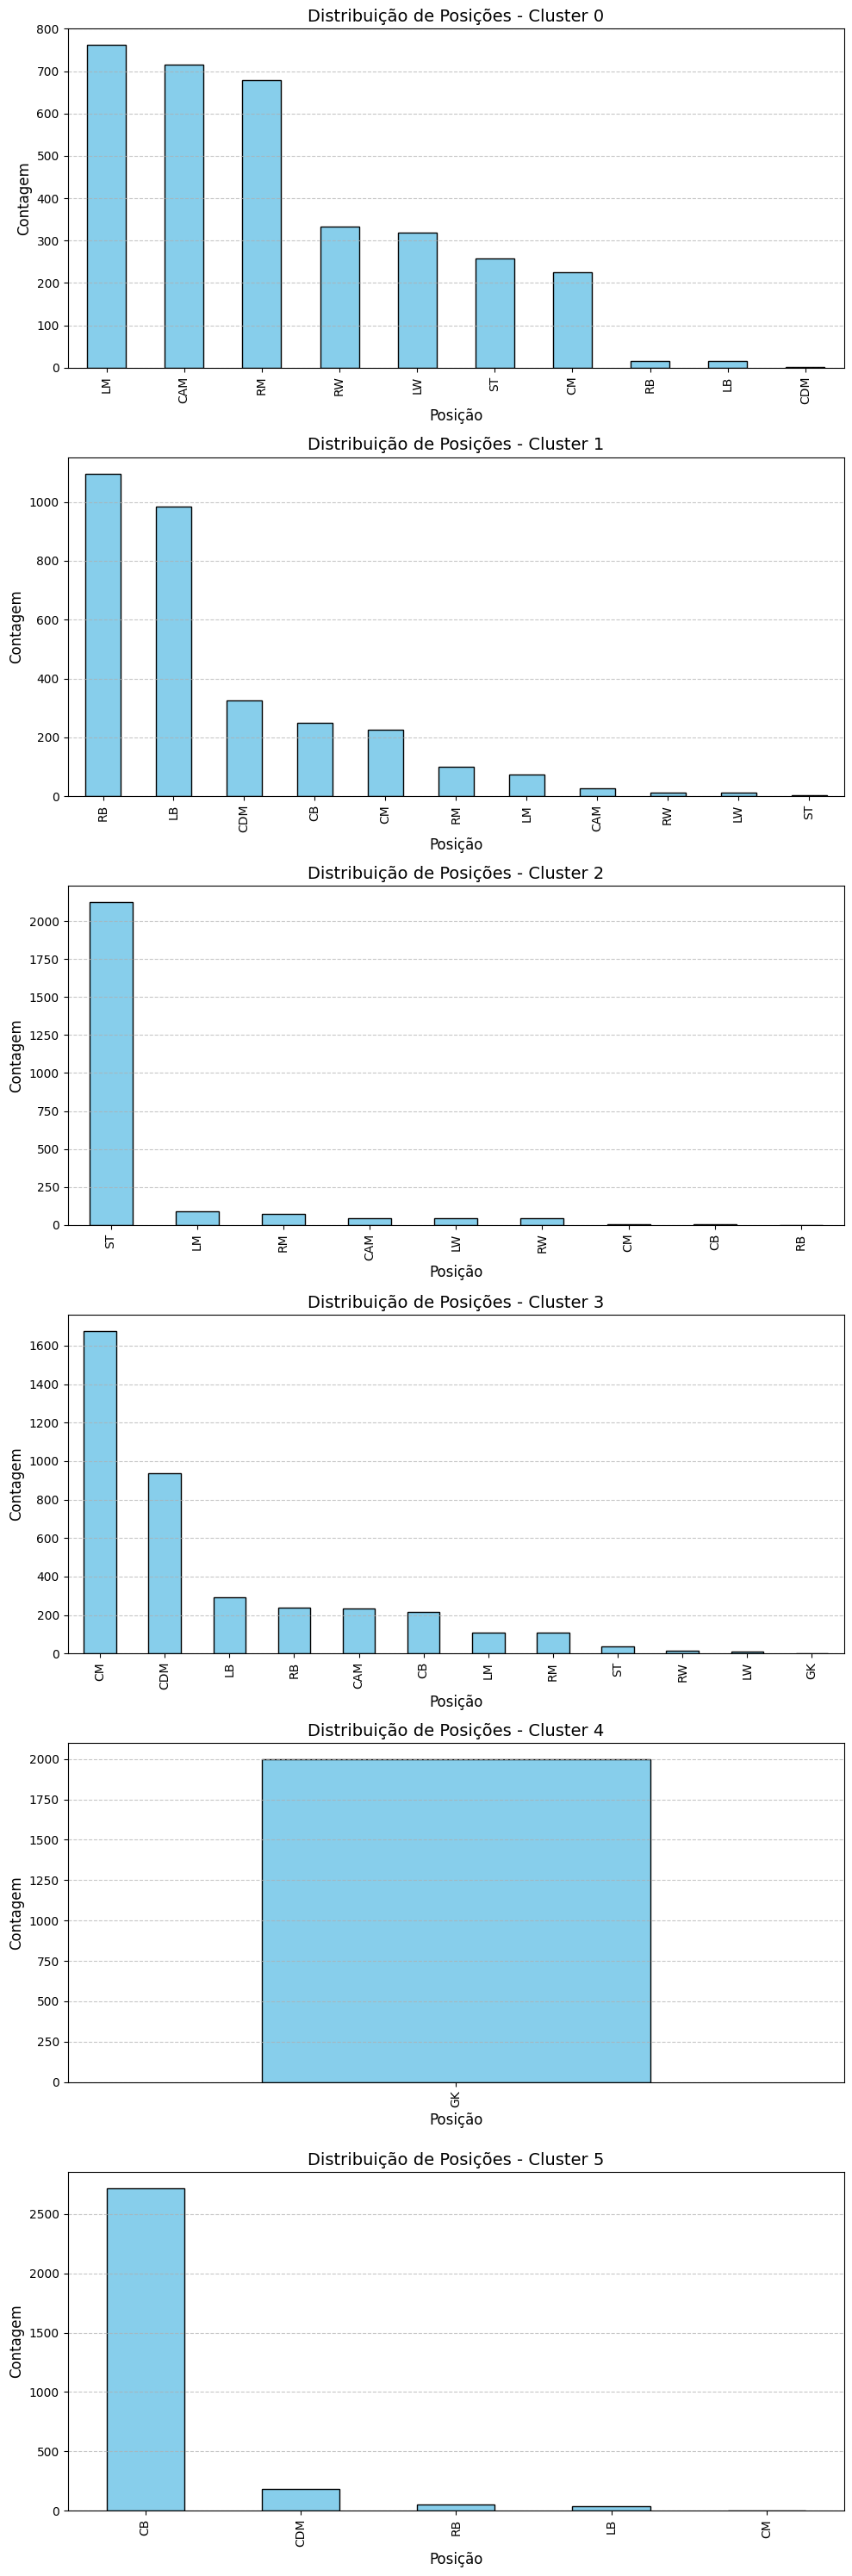

In [114]:
# Adicionando os rótulos dos clusters como uma coluna no dataset original
dataset['Cluster'] = kmeans_labels

# Obtendo os clusters únicos e ordenando-os
unique_clusters = sorted(dataset['Cluster'].unique())

# Criando um gráfico de barras para cada cluster
fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(10, 5 * len(unique_clusters)), sharex=False)

for i, cluster in enumerate(unique_clusters):
    # Filtrando as posições dos jogadores para o cluster atual
    cluster_data = dataset[dataset['Cluster'] == cluster]
    pos_counts = cluster_data['Position'].value_counts()  # Contando as posições

    # Criando o gráfico de barras
    ax = axes[i] if len(unique_clusters) > 1 else axes
    pos_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

    # Configurações do gráfico
    ax.set_title(f"Distribuição de Posições - Cluster {cluster}", fontsize=14)
    ax.set_ylabel('Contagem', fontsize=12)
    ax.set_xlabel('Posição', fontsize=12)  
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustando layout
plt.tight_layout()
plt.show()



Relembrando a nossa classificação:
- Cluster 0: Meias
  - De fato, as 5 posições mais comuns dentro deste cluster são meia central, meia esquerdo e direito, além de ala esquerdo e direito. Em seguida alguns atacantes também são colocados aqui

- Cluster 1: Laterais
  - Com folga as duas posições mais abundantes aqui são as de lateral esquerdo e direito. Em seguinda alguns jogadores defensivos do meio campo.

- Cluster 2: Atacantes
  - A expressa maioria é composta por atacantes.

- Cluster 3: Volantes
  - Composto por meio campo central e defensivo, expressando relativamente bem a posição de volante.

- Cluster 4: Goleiros
  - Apenas goleiros se encontram aqui, e são todos menos 1 goleiro que erroneamente está no cluster 3.

- Cluster 5: Zagueiros
  - COmposto praticamente apenas por zagueiros.


Considero portanto que obtive um enorme sucesso na clusteriazação utilizando o Kmeans, podendo interpretar bem os resultados dando sentido físico e prático, a partir do conhecimento prévio sobre a nossa base de dados. A clusterização com DBSCAN infelizmente não pode ser tão precisa, mas ainda assim conseguiu separar relativamente bem os dados que mais se destacam dos demais, sendo eles os goleiros.

## PARTE 4 - MEDIDAS DE SIMILARIDADE

Passos para agrupar 10 séries temporais em 3 grupos de acordo com a sua similaridade:
* Os dados das linhas temporais devem ser previamentre tratados, para evitar que haja distorção por conta da diferença de unidades ou escala.
* Todas as séries temporais devem ter o mesmo comprimento, estando portanto sincronizadas.
* Realizar um cálculo de correlação cruzada máxima entre cada par de séries
* Criar uma matriz de similaridade (semelhante ao que foi feito na análise de correlação de atributos neste trabalho)
* Aplicar um algoritmo de clusterização como o K-means ajustando o número de clusters para os 3 pedidos.
* Analisar a qualidade da clusterização usando métodos como índice de silhoueta, cotovelo, Davies-Bouldin, Calinski-Harabasz

Considerando que temos um número baixo de séries, número de clusters definidos e que a matriz de similaridade se adequa bem à uma clusterização baseada em distância, eu escolheria o K-means para realizar essa clusterização. Além disso, como a média das variáveis tem um sentido físico, é um método de fácil interpretação dos resultados.

Como exemplo de aplicabilidade do método descrito acima, tentando me manter no ramo de esportes, creio que pode ser utilizado para analisar a evolução de uma gama de atributos ao longo de meses e/ou anos em jogadores para analisar em que estágio de desenvolvimento este jogador está. Por exemplo, jogadores mais novos com um bom desenvolvimento podem tender a ter um aumento em estatísticas que indiquem um desenvolvimento corporal como aceleração e velocidade, enquanto outros mais velhos podem estar com estas características decaindo com o tempo. Em outros ramos, é clara a aplicabilidade de identificar padrões de venda entre diferentes produtos em uma região.

Uma outra alternativa ao uso de matriz de similaridade pode ser uma matriz de distâncias, entre elas a euclidiana se destaca pela sua simplicidade e aplicabilidade, mas outras como manhattan também são possíveis. Os passos são semelhantes ao anterior:
* Os dados devem ser previamente tratados, evitando assim distorção, além das séries terem o mesmo comprimento e estarem sincronizadas.
* Deve ser calculada a distância euclidiana entre cada par de séries temporais, dada como a soma do quadrado das diferenças ponto a ponto entre as séries.
* Criação de uma matriz de distância entre as series
* Aplicação de um algoritmo de clusterização
* Validação da clusterização com os métodos supracitados.